# Overview

## Introduction
I employ a simple, multi-step approach to classifying the bottle tap recordings as "top" or "bottom" which builds up from simple steps and prioritizes interpretability. I also prioritize "seeing" the data, so I listen to and vizualize the audio data we were sent. 

## Analysis plan

Step 1: Basic Data Extraction & Analysis

The goal is to digest and visualize the data. We will create vizualizations and audio files for the data. Then we will create simple summary statistics of the audio data to digest the immediate content of the data. 

Then we will see if we can see any obvious patterns just based on this simple data. We will use this exploration to identify features we think are predictive.

Step 2: Basic Classification from features extracted from the recordings

Using the summary statistics and extracted data described above, we will create a basic classifier based on distance to the labelled data using Cosine Similarity on the standardized features. We will weight the features based on their relevance (upweighting features more different between the labelled data relative to the variance in the sample and downwieghting those that are less different relative to the variance in the sample)
 
Use PCA to reduce the dimensionality and see if our classification features align with the separation we observe. 
 
Step 3 (not implemented): If we had more time, we might additionally consider extracting embeddings using a pretrained audio model, and use these to identify separation between the samples.

## Analysis summary
We find that there is a clear visual difference in the distribution of the frequencies for the top and the bottom, and we see that the frequencies tend to be collected within a few bands. We consider the first and third band frequency shares of the total power as a key predictor, along with the attack (time to peak) and release (time from peak to 10% of the power) within these bands as well as the second band. 

A naive guess would consider simply the peak frequency: if low frequency, than classify as "bottom", if high frequency, classify as "top", but we want to allow that there might be more subtle differences so we include the additional predictors as well. 

The actual classifier: 
- normalizes the data so the data are measured relative to the mean, 
- reweights the features based on the ratio of the difference between the labelled top/bottom observations and the standard deviation of the full sample
- calculates the cosine similarity to the labelled cases using these weighted features
- assigns the audio data to top/bottom depending on which cosine similarity is higher

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import librosa
import librosa.display
import soundfile as sf

from typing import TypeVar


from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [3]:
# Set up paths 
path_dict = {
    "dir_train":"./train"
    , "dir_inter":"./intermediate"
    , "dir_output":"./output"
    , "dir_logs":"./logs"
    , "dir_models":"./models"
    }    

all_file_paths = os.listdir(path_dict["dir_train"]) 

# Part 1: Read in and visualize data

In [4]:

# Function to read data
def read_spectrogram(file_name: str) -> pd.DataFrame:
    """
    Read spectrograms from CSV file where:
    - Row indices are frequency bands in Hz
    - Column names are time slices in milliseconds
    """
    # Load spectrogram
    spectrogram = pd.read_csv(file_name, index_col=0)
    
    # Convert column names to float (time values)
    spectrogram.columns = spectrogram.columns.astype(float)
    
    # Return spectrogram
    return spectrogram

# Function to visualize data
def visualize_spectrogram(spec_data: pd.DataFrame, title="Spectrogram") -> None:
    """
    Visualize spectrogram data with proper frequency and time axes
    """
    plt.figure(figsize=(12, 6))
    
    # Get frequency and time values
    freq_values = spec_data.index.astype(float).values
    time_values = spec_data.columns.astype(float).values
    
    # Plot spectrogram
    plt.pcolormesh(time_values, freq_values, spec_data.values, shading='gouraud', cmap='viridis')
    plt.colorbar(format='%+2.0f')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (ms)')
    plt.title(title)
      
    plt.tight_layout()
    plt.show()
    
    return None

# Function to convert spectrogram to audio
def spectrogram_to_audio(spec_data: pd.DataFrame, phase_iterations=10) -> np.ndarray:
    """
    Convert spectrogram to audio using Griffin-Lim algorithm
    
    Args:
        spec_data: DataFrame containing magnitude spectrogram
        phase_iterations: Number of iterations for phase reconstruction
        
    Returns:
        audio_data: Audio waveform as numpy array
    """
    # Convert DataFrame to numpy array
    spec_magnitude = spec_data.values
    
    # Griffin-Lim algorithm for phase reconstruction
    audio_data = librosa.griffinlim(
        spec_magnitude, 
        n_iter=phase_iterations, 
    )
    
    return audio_data

# Function to create audiofile
def create_audio_file(file_name: str, audio_data: np.ndarray, sr: int = 22050) -> None:
    """
    Create audio file from numpy array
    
    Args:
        file_name: Output file name (should end with .wav)
        audio_data: Audio data as numpy array
        sr: Sample rate (default: 22050)
    """ 
    
    # Normalize audio to prevent clipping
    audio_data = librosa.util.normalize(audio_data)
    
    # Save audio file using soundfile (librosa.output.write_wav is deprecated)
    sf.write(file_name, audio_data, sr)
    
    return None

# Example usage
def process_audio_file(input_csv: str, output_wav: str, sample_rate: int = 22050) -> None:
    """
    Process CSV spectrogram file to WAV audio file
    
    Args:
        input_csv: Path to input CSV file
        output_wav: Path to output WAV file
        sample_rate: Sample rate for the output audio
    """
    # Read spectrogram
    spec_data = read_spectrogram(input_csv)
    
    # Visualize spectrogram
    visualize_spectrogram(spec_data, title=f"Spectrogram: {input_csv}")
    
    # Convert to audio
    audio_data = spectrogram_to_audio(spec_data)
    
    # Save audio file
    create_audio_file(output_wav, audio_data, sample_rate)
    
    print(f"Successfully converted {input_csv} to {output_wav}")
    
    return spec_data, audio_data

['bottom.csv', 'top.csv', 'unlabeled_00.csv', 'unlabeled_10.csv', 'unlabeled_15.csv', 'unlabeled_22.csv', 'unlabeled_23.csv', 'unlabeled_25.csv', 'unlabeled_26.csv', 'unlabeled_27.csv', 'unlabeled_31.csv', 'unlabeled_37.csv', 'unlabeled_38.csv', 'unlabeled_42.csv', 'unlabeled_45.csv', 'unlabeled_56.csv', 'unlabeled_61.csv', 'unlabeled_68.csv', 'unlabeled_78.csv', 'unlabeled_85.csv', 'unlabeled_86.csv', 'unlabeled_88.csv', 'unlabeled_95.csv', 'unlabeled_98.csv']


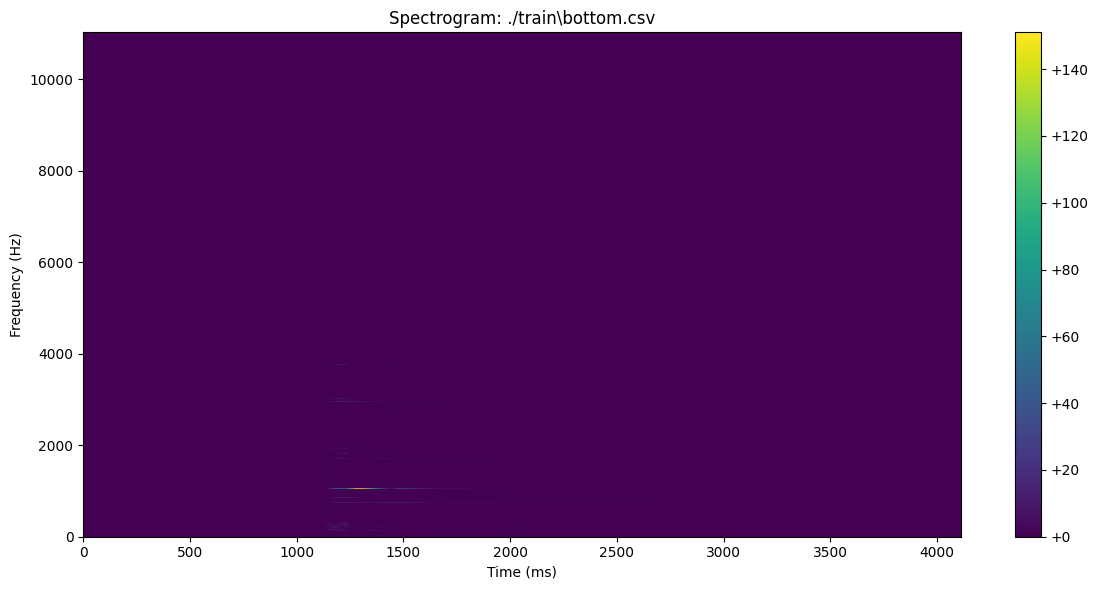

Successfully converted ./train\bottom.csv to ./output\bot.wav
              0.000000     23.219955    46.439909    69.659864    92.879819    \
frequency                                                                       
0.000000              0.0          0.0          0.0          0.0          0.0   
10.766602             0.0          0.0          0.0          0.0          0.0   
21.533203             0.0          0.0          0.0          0.0          0.0   
32.299805             0.0          0.0          0.0          0.0          0.0   
43.066406             0.0          0.0          0.0          0.0          0.0   
...                   ...          ...          ...          ...          ...   
10981.933594          0.0          0.0          0.0          0.0          0.0   
10992.700195          0.0          0.0          0.0          0.0          0.0   
11003.466797          0.0          0.0          0.0          0.0          0.0   
11014.233398          0.0          0.0         

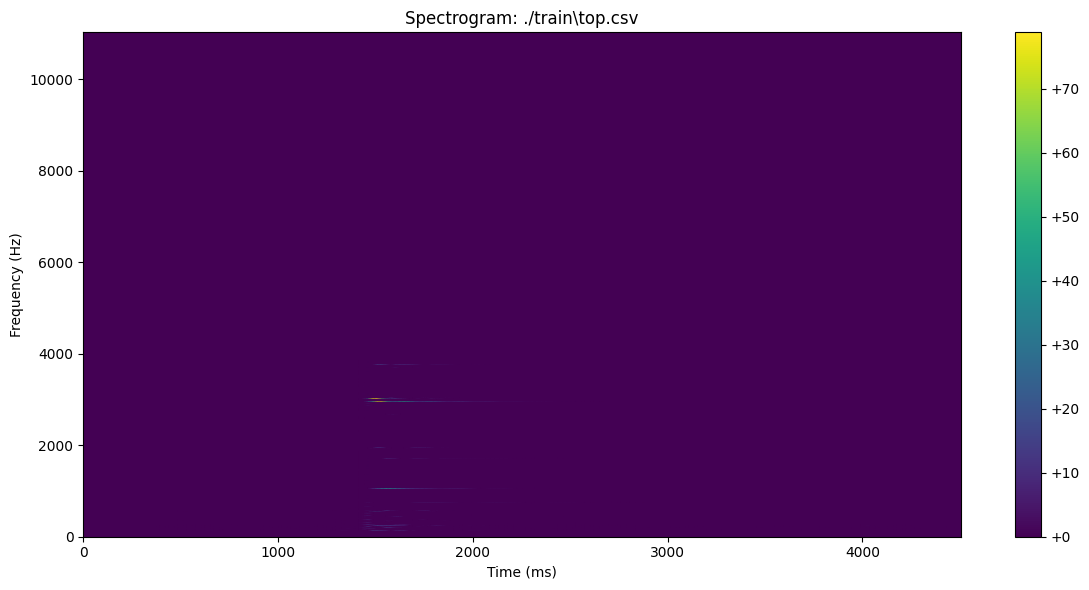

Successfully converted ./train\top.csv to ./output\top.wav
              0.000000     23.219955    46.439909    69.659864    92.879819    \
frequency                                                                       
0.000000              0.0          0.0          0.0          0.0          0.0   
10.766602             0.0          0.0          0.0          0.0          0.0   
21.533203             0.0          0.0          0.0          0.0          0.0   
32.299805             0.0          0.0          0.0          0.0          0.0   
43.066406             0.0          0.0          0.0          0.0          0.0   
...                   ...          ...          ...          ...          ...   
10981.933594          0.0          0.0          0.0          0.0          0.0   
10992.700195          0.0          0.0          0.0          0.0          0.0   
11003.466797          0.0          0.0          0.0          0.0          0.0   
11014.233398          0.0          0.0          0.

In [5]:
## Read in some data
print(all_file_paths)
bot_path = all_file_paths[0] ## Bottom
top_path = all_file_paths[1] ## Top



spec_bot, audio_bot = process_audio_file(
    input_csv=os.path.join(path_dict["dir_train"], bot_path)
    , output_wav=os.path.join(path_dict["dir_output"], "bot.wav")
) 
print(spec_bot)
print(audio_bot)

spec_top, audio_top = process_audio_file(
    input_csv=os.path.join(path_dict["dir_train"], top_path)
    , output_wav=os.path.join(path_dict["dir_output"], "top.wav")
) 
print(spec_top)
print(audio_top)

In [ ]:
def analyze_spectral_distribution(spec_data: pd.DataFrame, title_prefix="Spectral Analysis"):
    """
    Analyze and visualize the distribution of power across frequencies and time
    
    Args:
        spec_data: DataFrame containing the spectrogram data
        title_prefix: Prefix for plot titles
    """
    # Get frequency and time values
    freq_values = spec_data.index.astype(float).values
    time_values = spec_data.columns.astype(float).values
    
    # Create a figure with 3 subplots (original spectrogram, frequency distribution, time distribution)
    fig, axs = plt.subplots(3, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [1, 1, 1]})
    
    # Plot 1: Original spectrogram
    pcm = axs[0].pcolormesh(time_values, freq_values, spec_data.values, shading='gouraud', cmap='viridis')
    fig.colorbar(pcm, ax=axs[0], format='%+2.0f')
    axs[0].set_ylabel('Frequency (Hz)')
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_title(f"{title_prefix}: Full Spectrogram")
    
    # Plot 2: Frequency distribution (sum across time)
    frequency_power = spec_data.sum(axis=1)  # Sum across all time slices
    axs[1].plot(freq_values, frequency_power, 'r-', linewidth=2)
    axs[1].fill_between(freq_values, frequency_power, alpha=0.3, color='red')
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Total Power')
    axs[1].set_title(f"{title_prefix}: Frequency Power Distribution")
    axs[1].grid(True, linestyle='--', alpha=0.7)
    
    # Plot 3: Time distribution (sum across frequency)
    time_power = spec_data.sum(axis=0)  # Sum across all frequencies
    axs[2].plot(time_values, time_power, 'b-', linewidth=2)
    axs[2].fill_between(time_values, time_power, alpha=0.3, color='blue')
    axs[2].set_xlabel('Time (ms)')
    axs[2].set_ylabel('Total Power')
    axs[2].set_title(f"{title_prefix}: Temporal Power Distribution")
    axs[2].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig, axs
 

def extract_spectral_features(spec_data: pd.DataFrame, bands: list) -> dict:
    """
    Extract numerical features from the spectrogram that could be useful for classification
    
    Args:
        spec_data: DataFrame containing the spectrogram data
        bands: List of tuples specifying frequency bands to analyze [(low1, high1), (low2, high2), ...]
        
    Returns:
        features: Dictionary of extracted features
    """
    # Get frequency and time values
    freq_values = spec_data.index.astype(float).values
    
    # Calculate frequency distribution
    freq_power = spec_data.sum(axis=1)
    time_power = spec_data.sum(axis=0)
    
    # Find peak frequency (frequency with maximum power)
    peak_freq_idx = freq_power.argmax()
    peak_frequency = freq_values[peak_freq_idx]
    
    # Calculate spectral centroid (weighted average of frequencies)
    spectral_centroid = np.sum(freq_values * freq_power) / np.sum(freq_power)
    
    # Calculate spectral bandwidth (weighted standard deviation of frequencies)
    spectral_bandwidth = np.sqrt(np.sum(((freq_values - spectral_centroid) ** 2) * freq_power) / np.sum(freq_power))
    
    # Calculate power in the bands
    band_power = []
    for band in bands:
        low_freq, high_freq = band
        band_mask = (freq_values >= low_freq) & (freq_values < high_freq)
        band_power.append(np.sum(freq_power[band_mask]))    

    total_band_power = np.sum(band_power)
    for i in range(len(band_power)):
        band_power[i] /= total_band_power  
 
    # Calculate temporal features
    max_power = np.max(time_power)
    max_power_idx = time_power.argmax()
    last_silence_idx = time_power[:max_power_idx][time_power < (0.01 * max_power)].index[-1]
    release_10pct_idx = time_power[time_power > (0.1 * max_power)].index[-1]
        
    attack_time = max_power_idx - last_silence_idx
    release_time = release_10pct_idx - max_power_idx 

    peak_time_idx = time_power.argmax()
    peak_time = time_power.index[peak_time_idx]

    ## Attack/release for each band    
    attack_times = []
    release_times = []
    for band in bands:
        low_freq, high_freq = band
        band_mask = (freq_values >= low_freq) & (freq_values < high_freq)
        band_time_power = spec_data[band_mask].sum(axis=0)

        max_power = np.max(band_time_power)
        max_power_idx = band_time_power.argmax()
        last_silence_idx = band_time_power[:max_power_idx][band_time_power < (0.01 * max_power)].index[-1]
        release_10pct_idx = band_time_power[band_time_power > (0.1 * max_power)].index[-1]
         
        attack_times.append(max_power_idx - last_silence_idx)
        release_times.append(release_10pct_idx - max_power_idx)
     
    
    # Return features as a dictionary
    features = {
        'peak_frequency': peak_frequency,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,  
        'peak_time': peak_time,
        'total_power': np.sum(spec_data.values),
        'max_power': np.max(spec_data.values), 
        'attack_time': attack_time,
        'release_time': release_time,
        'band_power': total_band_power,
        ## Add the band powers
        **{f'band_{i}_power': band_power[i] for i in range(len(band_power))},
        ## Add the band attack/release times
        **{f'band_{i}_attack_time': attack_times[i] for i in range(len(attack_times))}, 
        **{f'band_{i}_release_time': release_times[i] for i in range(len(release_times))}, 
    }
    
    return features
 
## Extract spectrum after a band pass filter with any number of bands
def band_pass_filter(spec_data: pd.DataFrame, bands: list) -> pd.DataFrame:
    """
    Apply a band-pass filter to the spectrogram data
    
    Args:
        spec_data: DataFrame containing the spectrogram data
        bands: List of tuples specifying frequency bands to keep [(low1, high1), (low2, high2), ...]
        
    Returns:
        filtered_spec: DataFrame with band-pass filtered spectrogram data
    """
    # Create a copy of the original spectrogram to avoid modifying it directly
    filtered_spec = spec_data.copy()
    
    # Iterate over each frequency and get the full list of indices to not zero out
    indices_to_keep = []
    for band in bands:
        low_freq, high_freq = band
        freq_mask = (filtered_spec.index >= low_freq) & (filtered_spec.index <= high_freq)
        indices_to_keep += list(filtered_spec.index[freq_mask])

    filtered_spec.loc[~filtered_spec.index.isin(indices_to_keep)] = 0
    return filtered_spec




{'peak_frequency': 1065.8935546875,
 'spectral_centroid': 1119.8569720635942,
 'spectral_bandwidth': 814.2829351344828,
 'peak_time': 1207.4376417233561,
 'total_power': 3656.8767249345947,
 'max_power': 151.00671,
 'attack_time': 5.560090702947846,
 'release_time': 1526.9569160997733,
 'band_power': 3656.8767249345965,
 'band_0_power': 1.0,
 'band_0_attack_time': 5.560090702947846,
 'band_0_release_time': 1526.9569160997733}

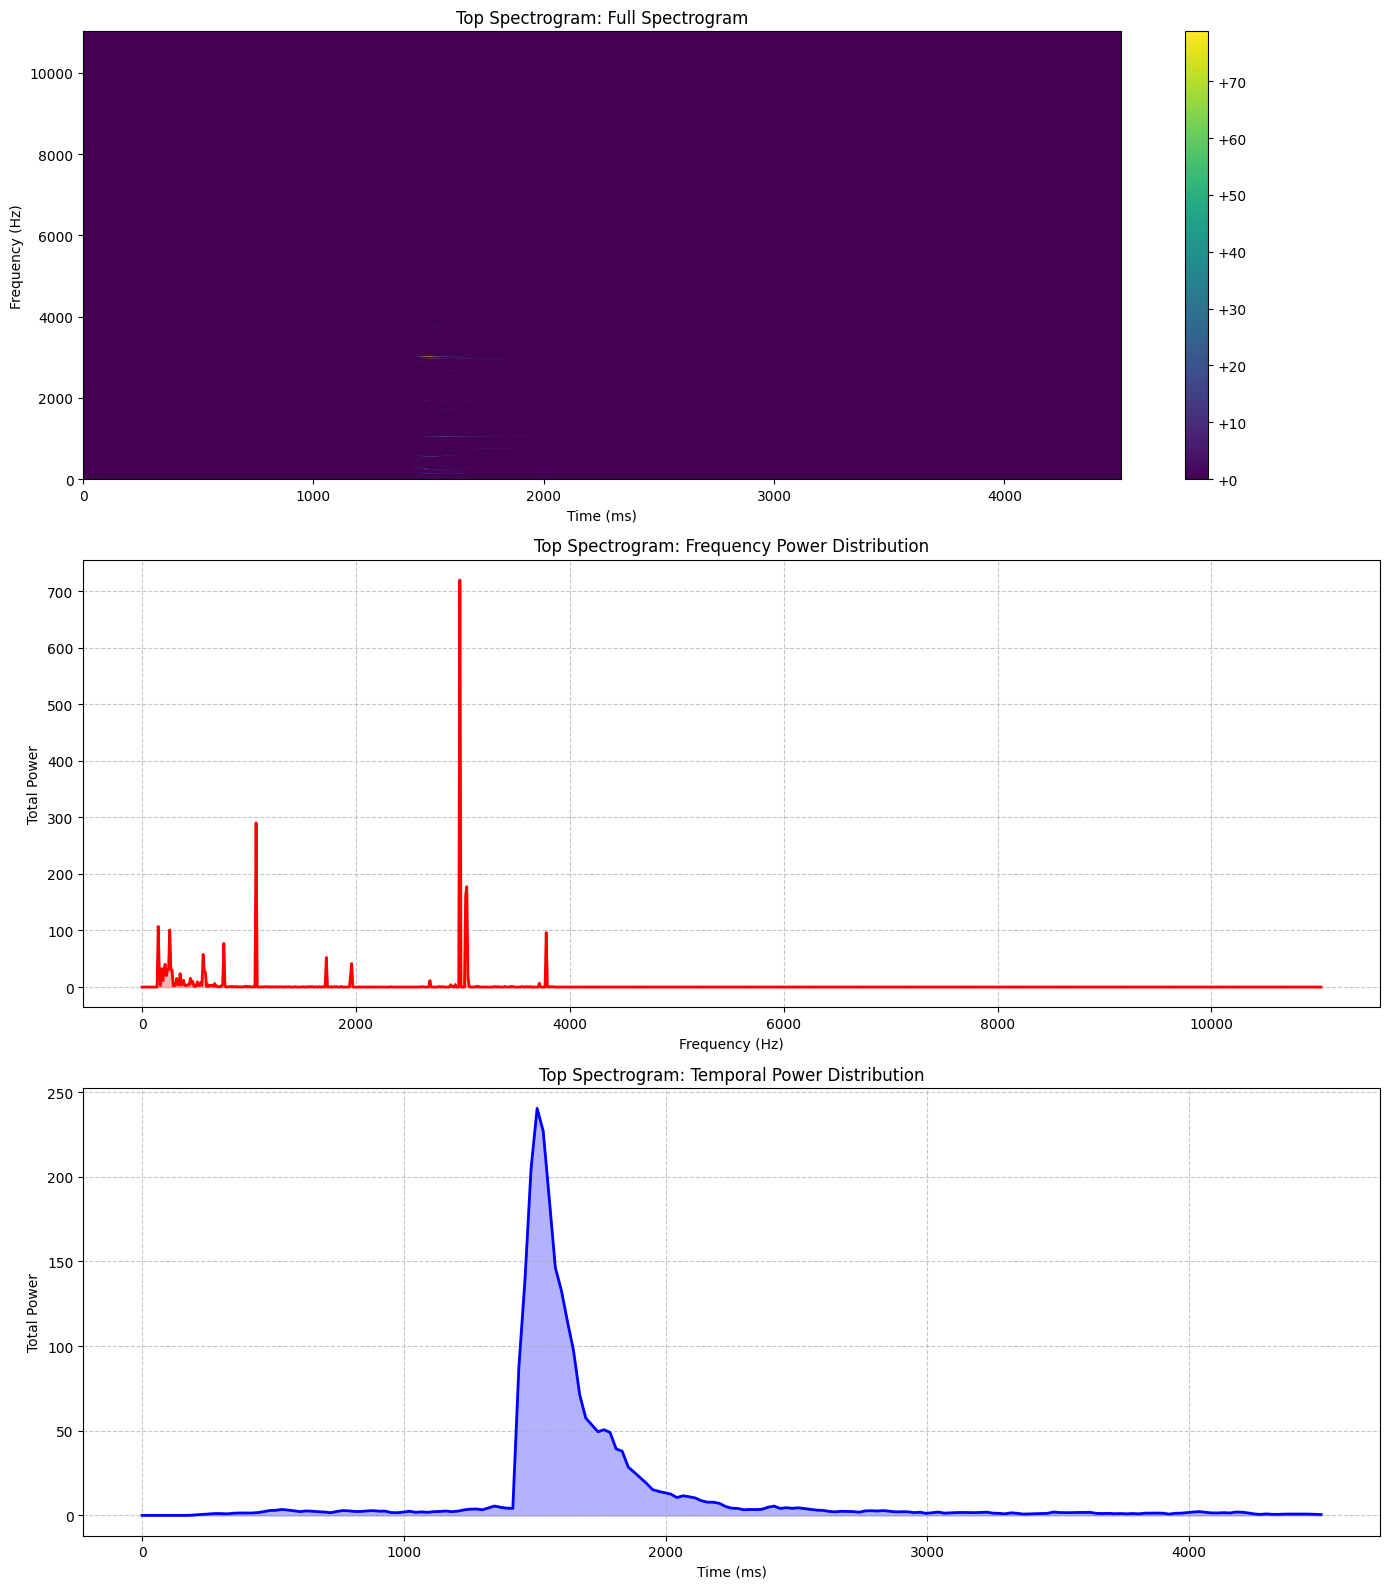

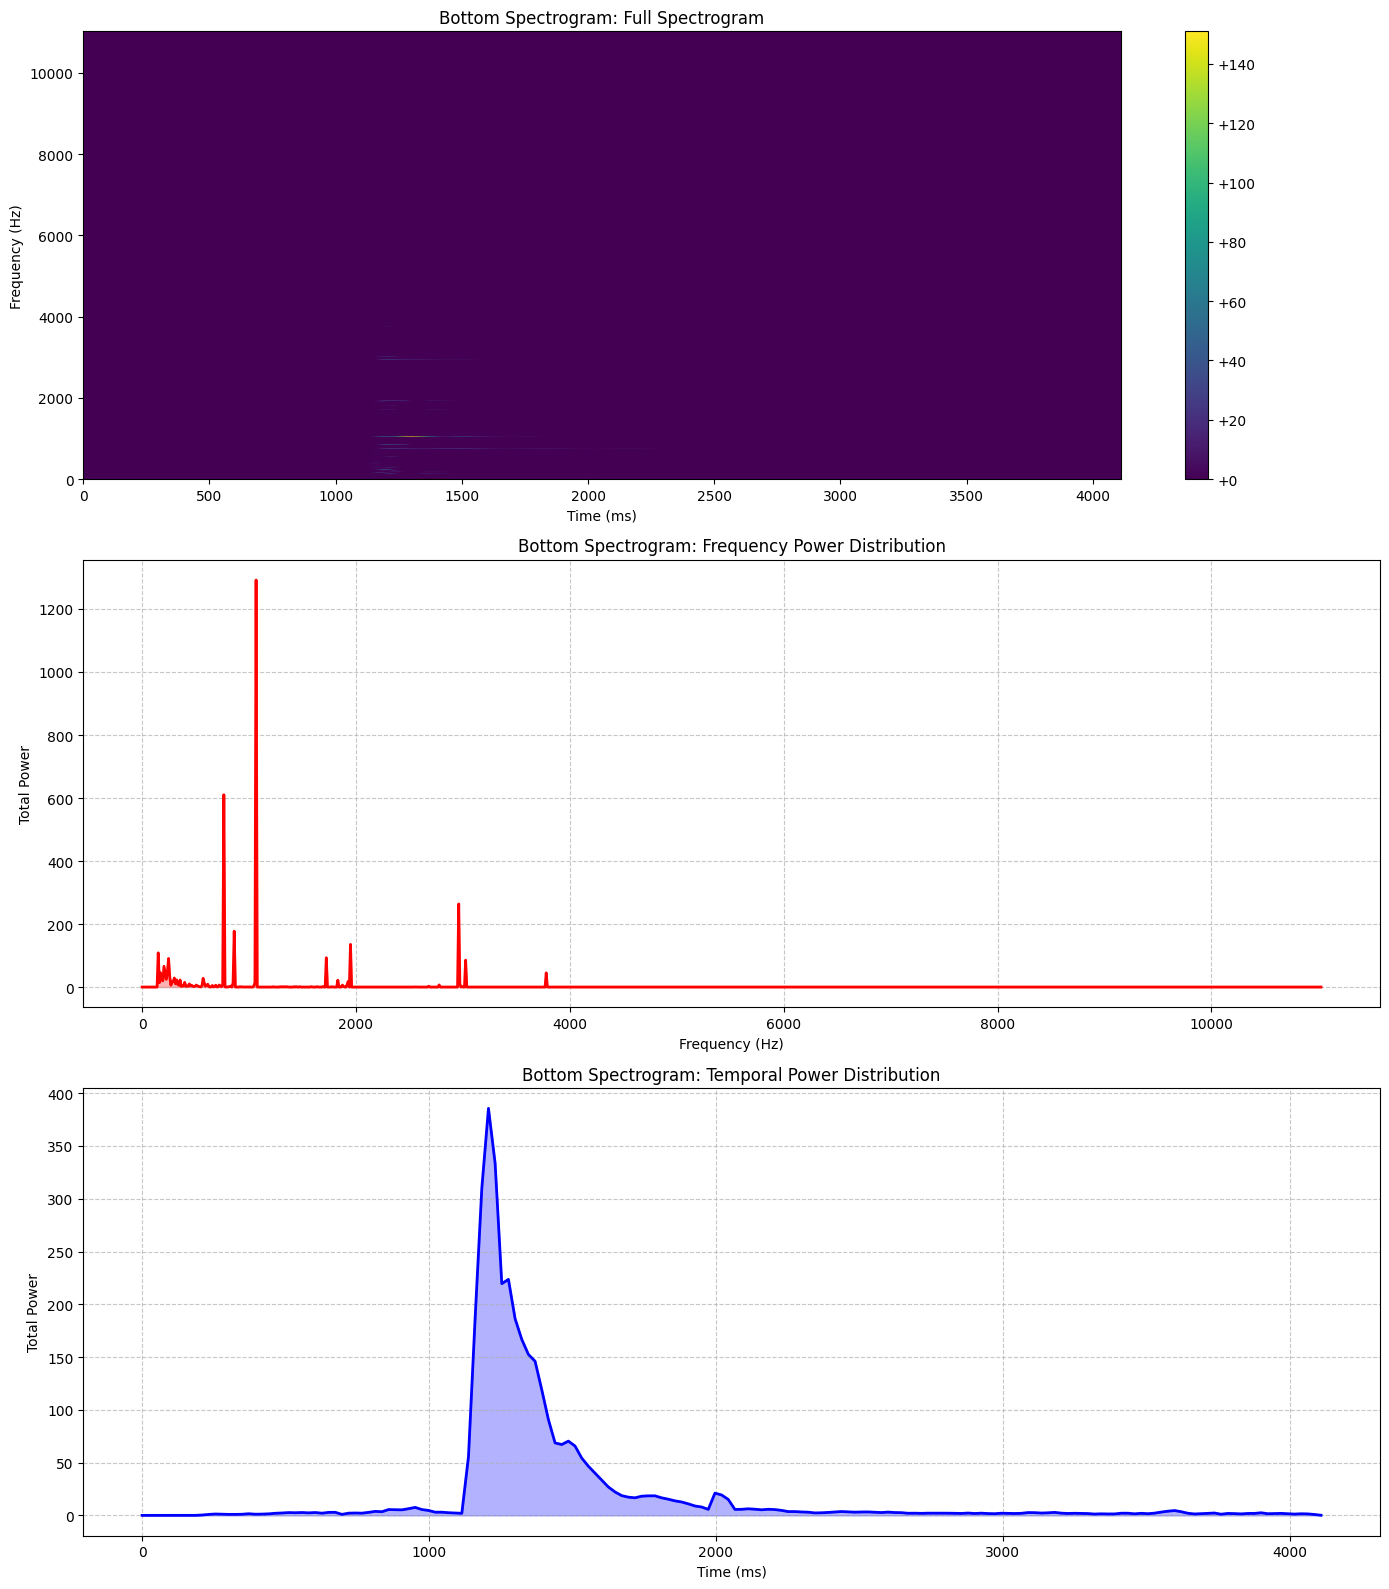

In [7]:
# Run the analysis
analyze_spectral_distribution(spec_top, title_prefix="Top Spectrogram")
extract_spectral_features(spec_top, bands=[(0, 5000)])

analyze_spectral_distribution(spec_bot, title_prefix="Bottom Spectrogram")
extract_spectral_features(spec_bot, bands=[(0, 5000)])
### See significant differences in the spectral distributions, and small differences in in the temporal distributions

In [8]:
### Now let's scale up and extract these features into a dataframe for all the spectrograms
### It seems likely we can do the classification based on the spectral features alone. 
### We may want to consider more than just peak, or add a low pass filter, but we can do that later. 

def extract_features_from_all_spectrograms(file_paths: list, bands: list ) -> (pd.DataFrame, list):
    """
    Extract features from all spectrograms in the given file paths and save to a CSV file
    
    Args:
        file_paths: List of file paths to spectrogram CSV files
        output_csv: Path to output CSV file
    """
    # Initialize an empty list to store features
    all_features = []
    all_spectra = []
    # Iterate over each file path
    for file_path in file_paths:
        # Read the spectrogram
        spec_data = read_spectrogram(path_dict['dir_train']+"/"+file_path)
 
        # Extract features
        features = extract_spectral_features(spec_data, bands = bands)       
        features['file_name'] = file_path 

        # Run spectral analysis
        fig_file, _ = analyze_spectral_distribution(spec_data, title_prefix=file_path)
        plt.savefig(path_dict['dir_output']+"/"+file_path[0:-4]+".png", dpi=300, bbox_inches='tight')
        plt.close(fig_file) 

        # Save the audio file
        audio_data = spectrogram_to_audio(spec_data)
        create_audio_file(path_dict['dir_output']+"/"+file_path[0:-4]+".wav", audio_data, sr=22050)

        # Get a band-passed version of the spectrogram (600-1200, 1600-2000, 2400-4000 Hz)
        band_passed = band_pass_filter(spec_data, bands = bands)
        create_audio_file(path_dict['dir_output']+"/"+file_path[0:-4]+"_band_passed.wav", spectrogram_to_audio(band_passed), sr=22050)
        
        # Append the features to the list
        all_features.append(features)
        all_spectra.append(spec_data)

    # Convert the list of features to a DataFrame
    features_df = pd.DataFrame(all_features)
    
    return features_df, all_spectra


In [9]:

# Read in the data
features_df, all_spectra = extract_features_from_all_spectrograms(all_file_paths, bands = [(750, 1400), (1600, 2000), (2600, 3200), (3500, 4000)])
features_df['file_type'] = features_df['file_name'].apply(lambda x: 'Bottom' if 'bot' in x else 'Top' if 'top' in x else 'Unknown') 

print(features_df.head())

   peak_frequency  spectral_centroid  spectral_bandwidth    peak_time  \
0     1065.893555        1119.856972          814.282935  1207.437642   
1     2971.582031        1823.566405         1257.999652  1509.297052   
2     1065.893555        1651.076504         1152.426229  1462.857143   
3     1065.893555        1266.531749          941.148875  1811.156463   
4     1065.893555        1749.821042         1150.686511  1346.757370   

   total_power   max_power  attack_time  release_time   band_power  \
0  3656.876725  151.006710     5.560091   1526.956916  2835.303525   
1  2528.973893   78.799866    18.560091   1815.816327  1727.884281   
2  2425.712016   64.235410    16.560091   1724.936508  1875.792954   
3  3204.963448   99.360030     8.340136   2011.795918  2392.228587   
4  2852.048141  112.267750    11.560091   1660.276644  2263.327488   

   band_0_power  ...  band_0_attack_time  band_1_attack_time  \
0      0.752340  ...            8.560091            5.560091   
1      0.227

In [10]:
## Now we know something about these data. Let's classify them. Let's look at a plot of the features 
## let's do a pairwise plot with the three main bands, and color the "bottom" and "top" points separately

def plot_feature_pairs(features_df: pd.DataFrame, feature_cols: list, title="Feature Pair Plot", hue: str = "file_type") -> None:
    """
    Plot pairwise relationships between features in the DataFrame"
    """
    # Select features to plot
    # Create a pairplot
    sns.pairplot(features_df, vars=feature_cols, hue=hue, palette='Set1', diag_kind='kde')
    plt.suptitle(title, y=1.02)
    plt.show()
    return None


# Plot pairwise relationships between features
band_power_cols = [ f'band_{i}_power' for i in range(4) ]
overall_features = ["band_power", "peak_frequency", "spectral_centroid", "spectral_bandwidth", "total_power", "max_power", "attack_time", "release_time"]
band_attack_cols = [ f'band_{i}_attack_time' for i in range(4) ]
band_release_cols = [ f'band_{i}_release_time' for i in range(4) ]
all_cols = band_power_cols + overall_features + band_attack_cols + band_release_cols


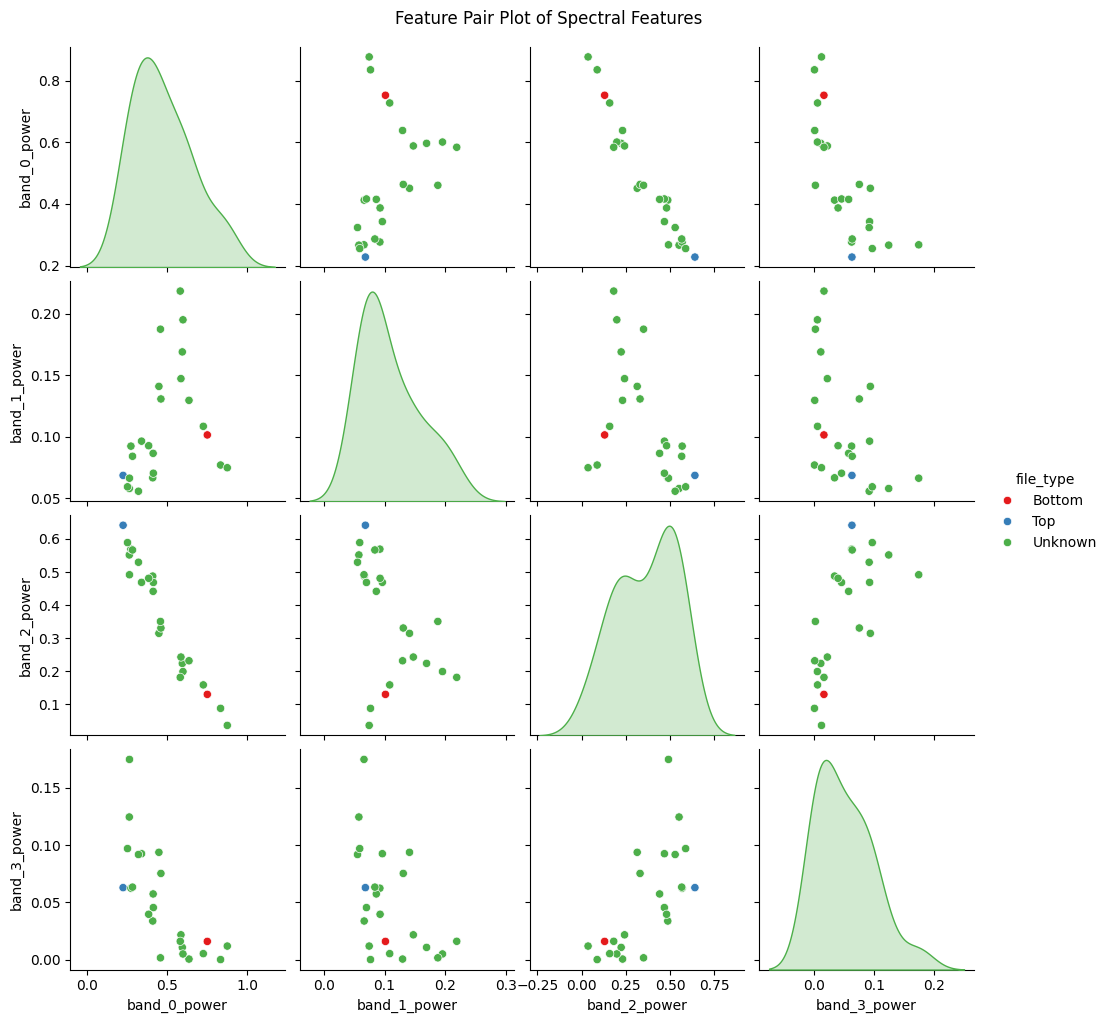

In [11]:

plot_feature_pairs(features_df, feature_cols= band_power_cols,  title="Feature Pair Plot of Spectral Features")

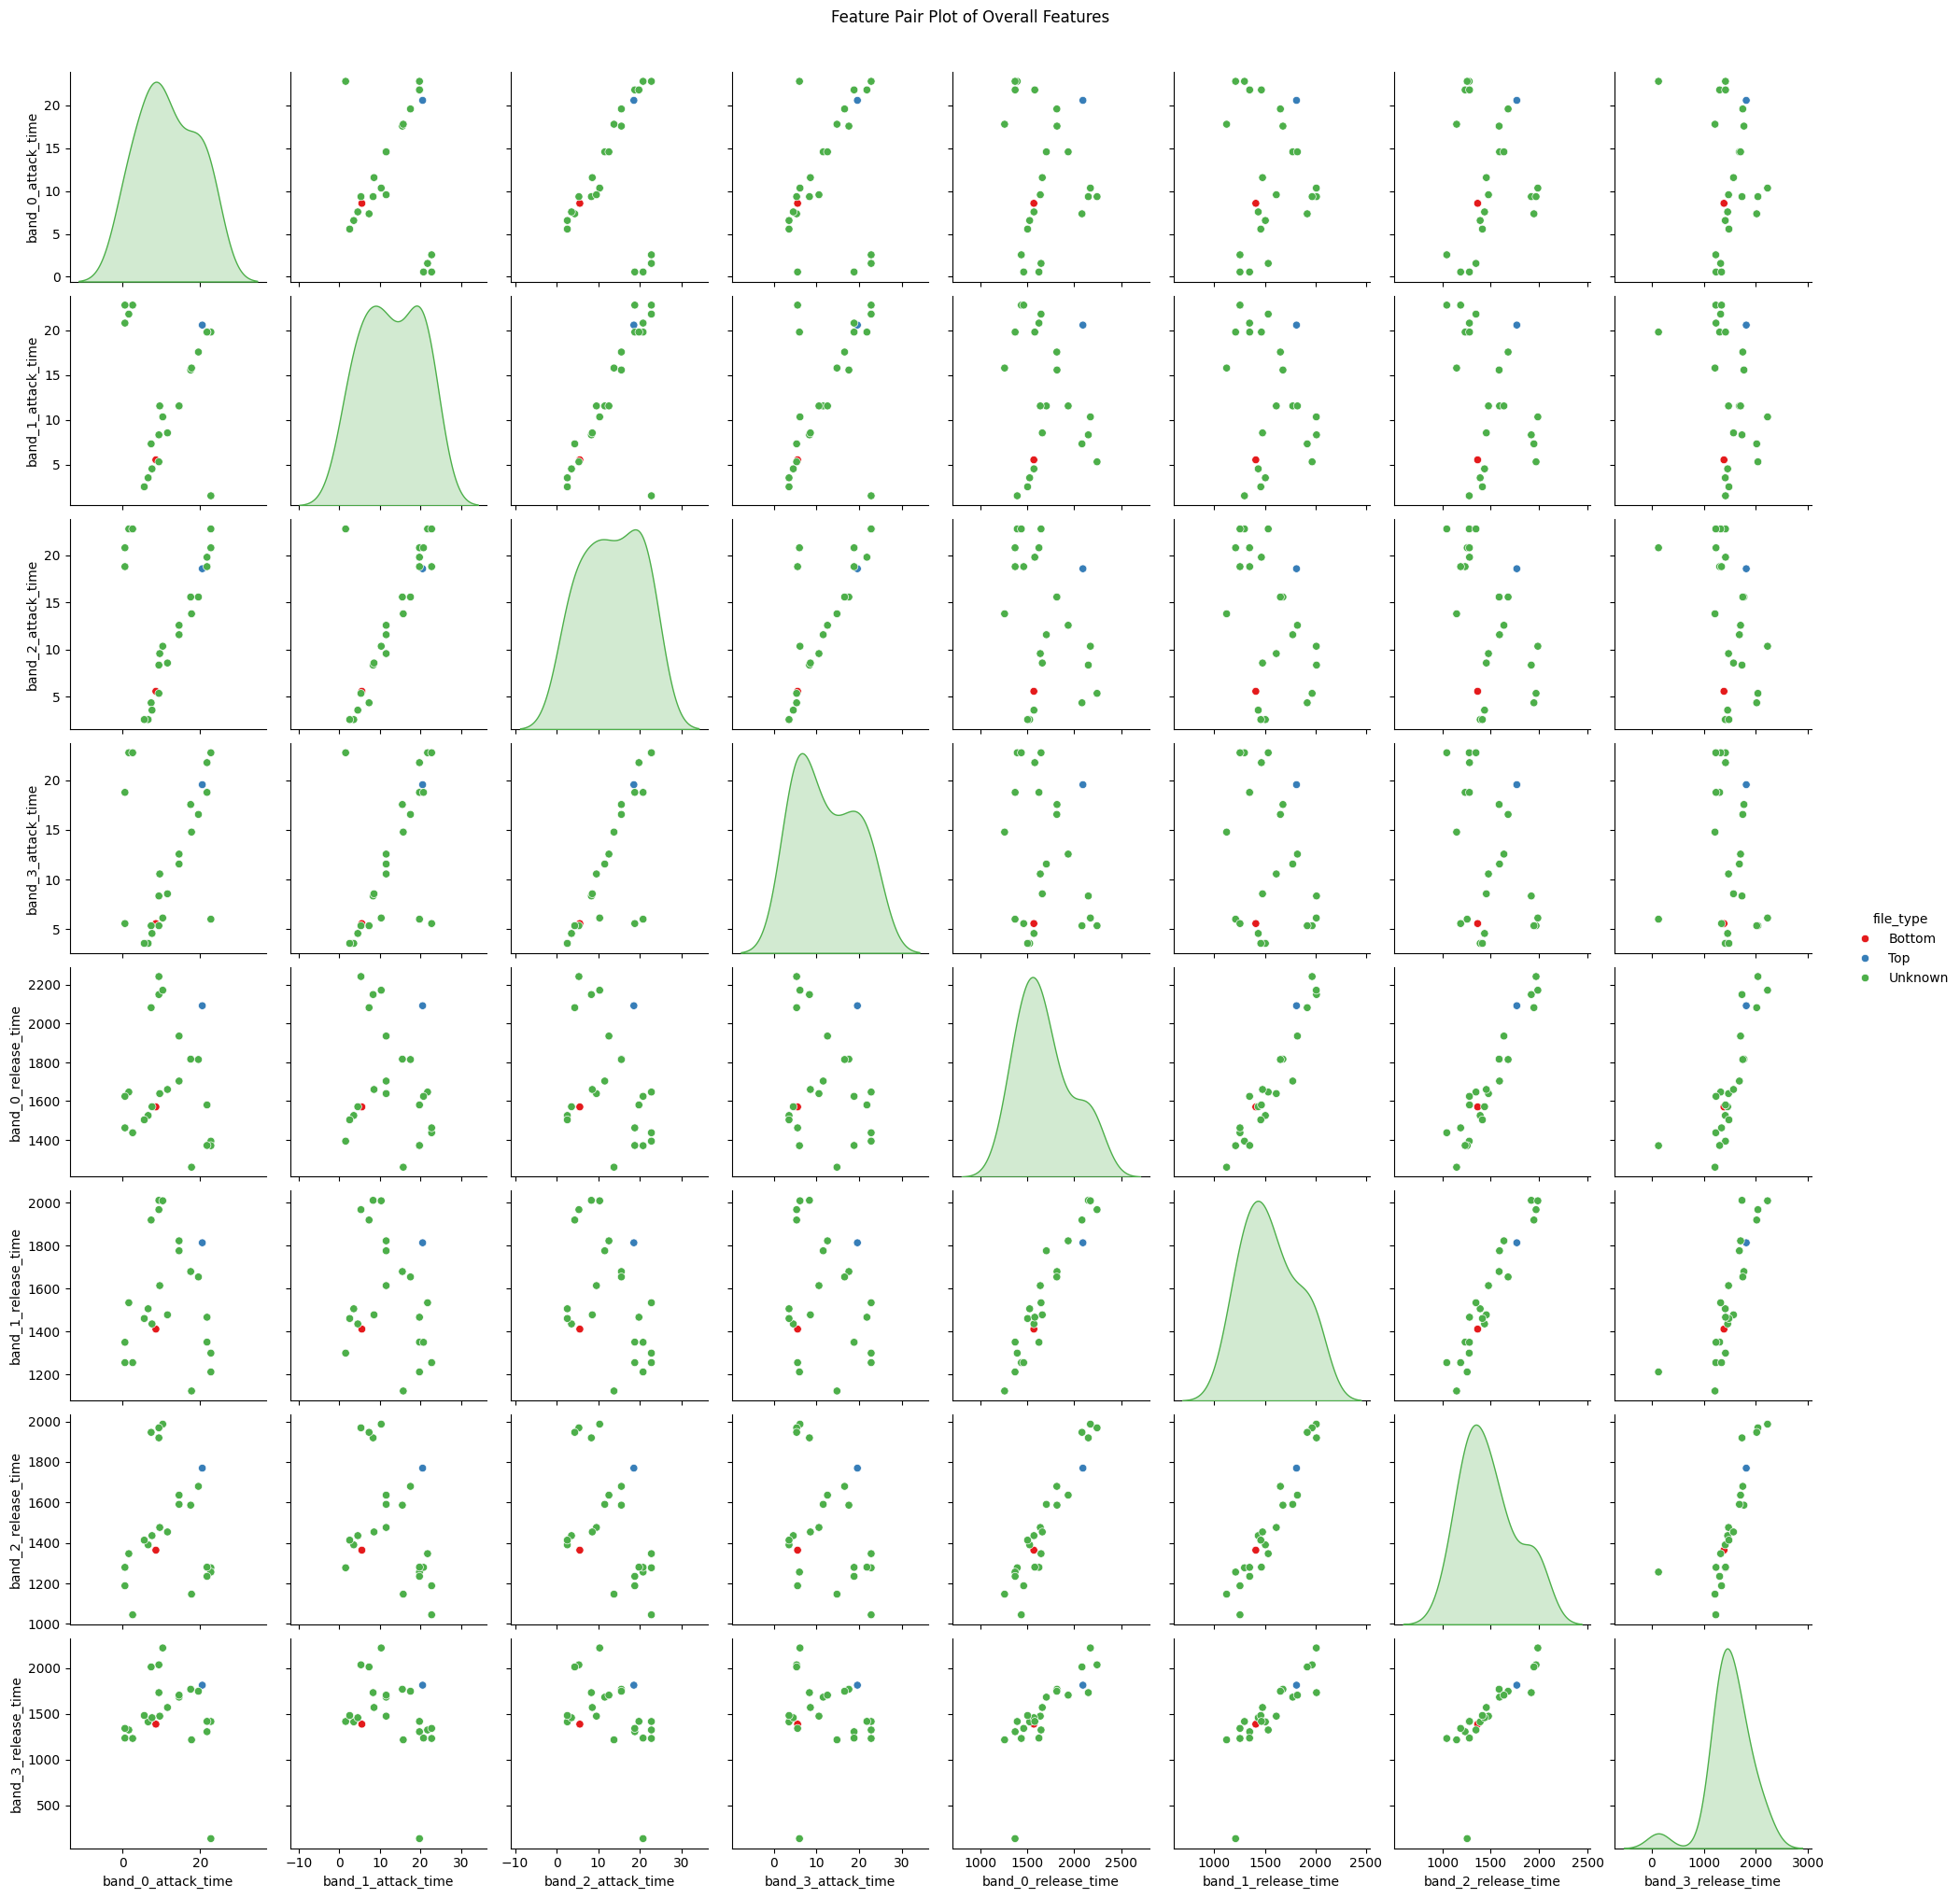

In [12]:

plot_feature_pairs(features_df, feature_cols= band_attack_cols+band_release_cols,  title="Feature Pair Plot of Overall Features")

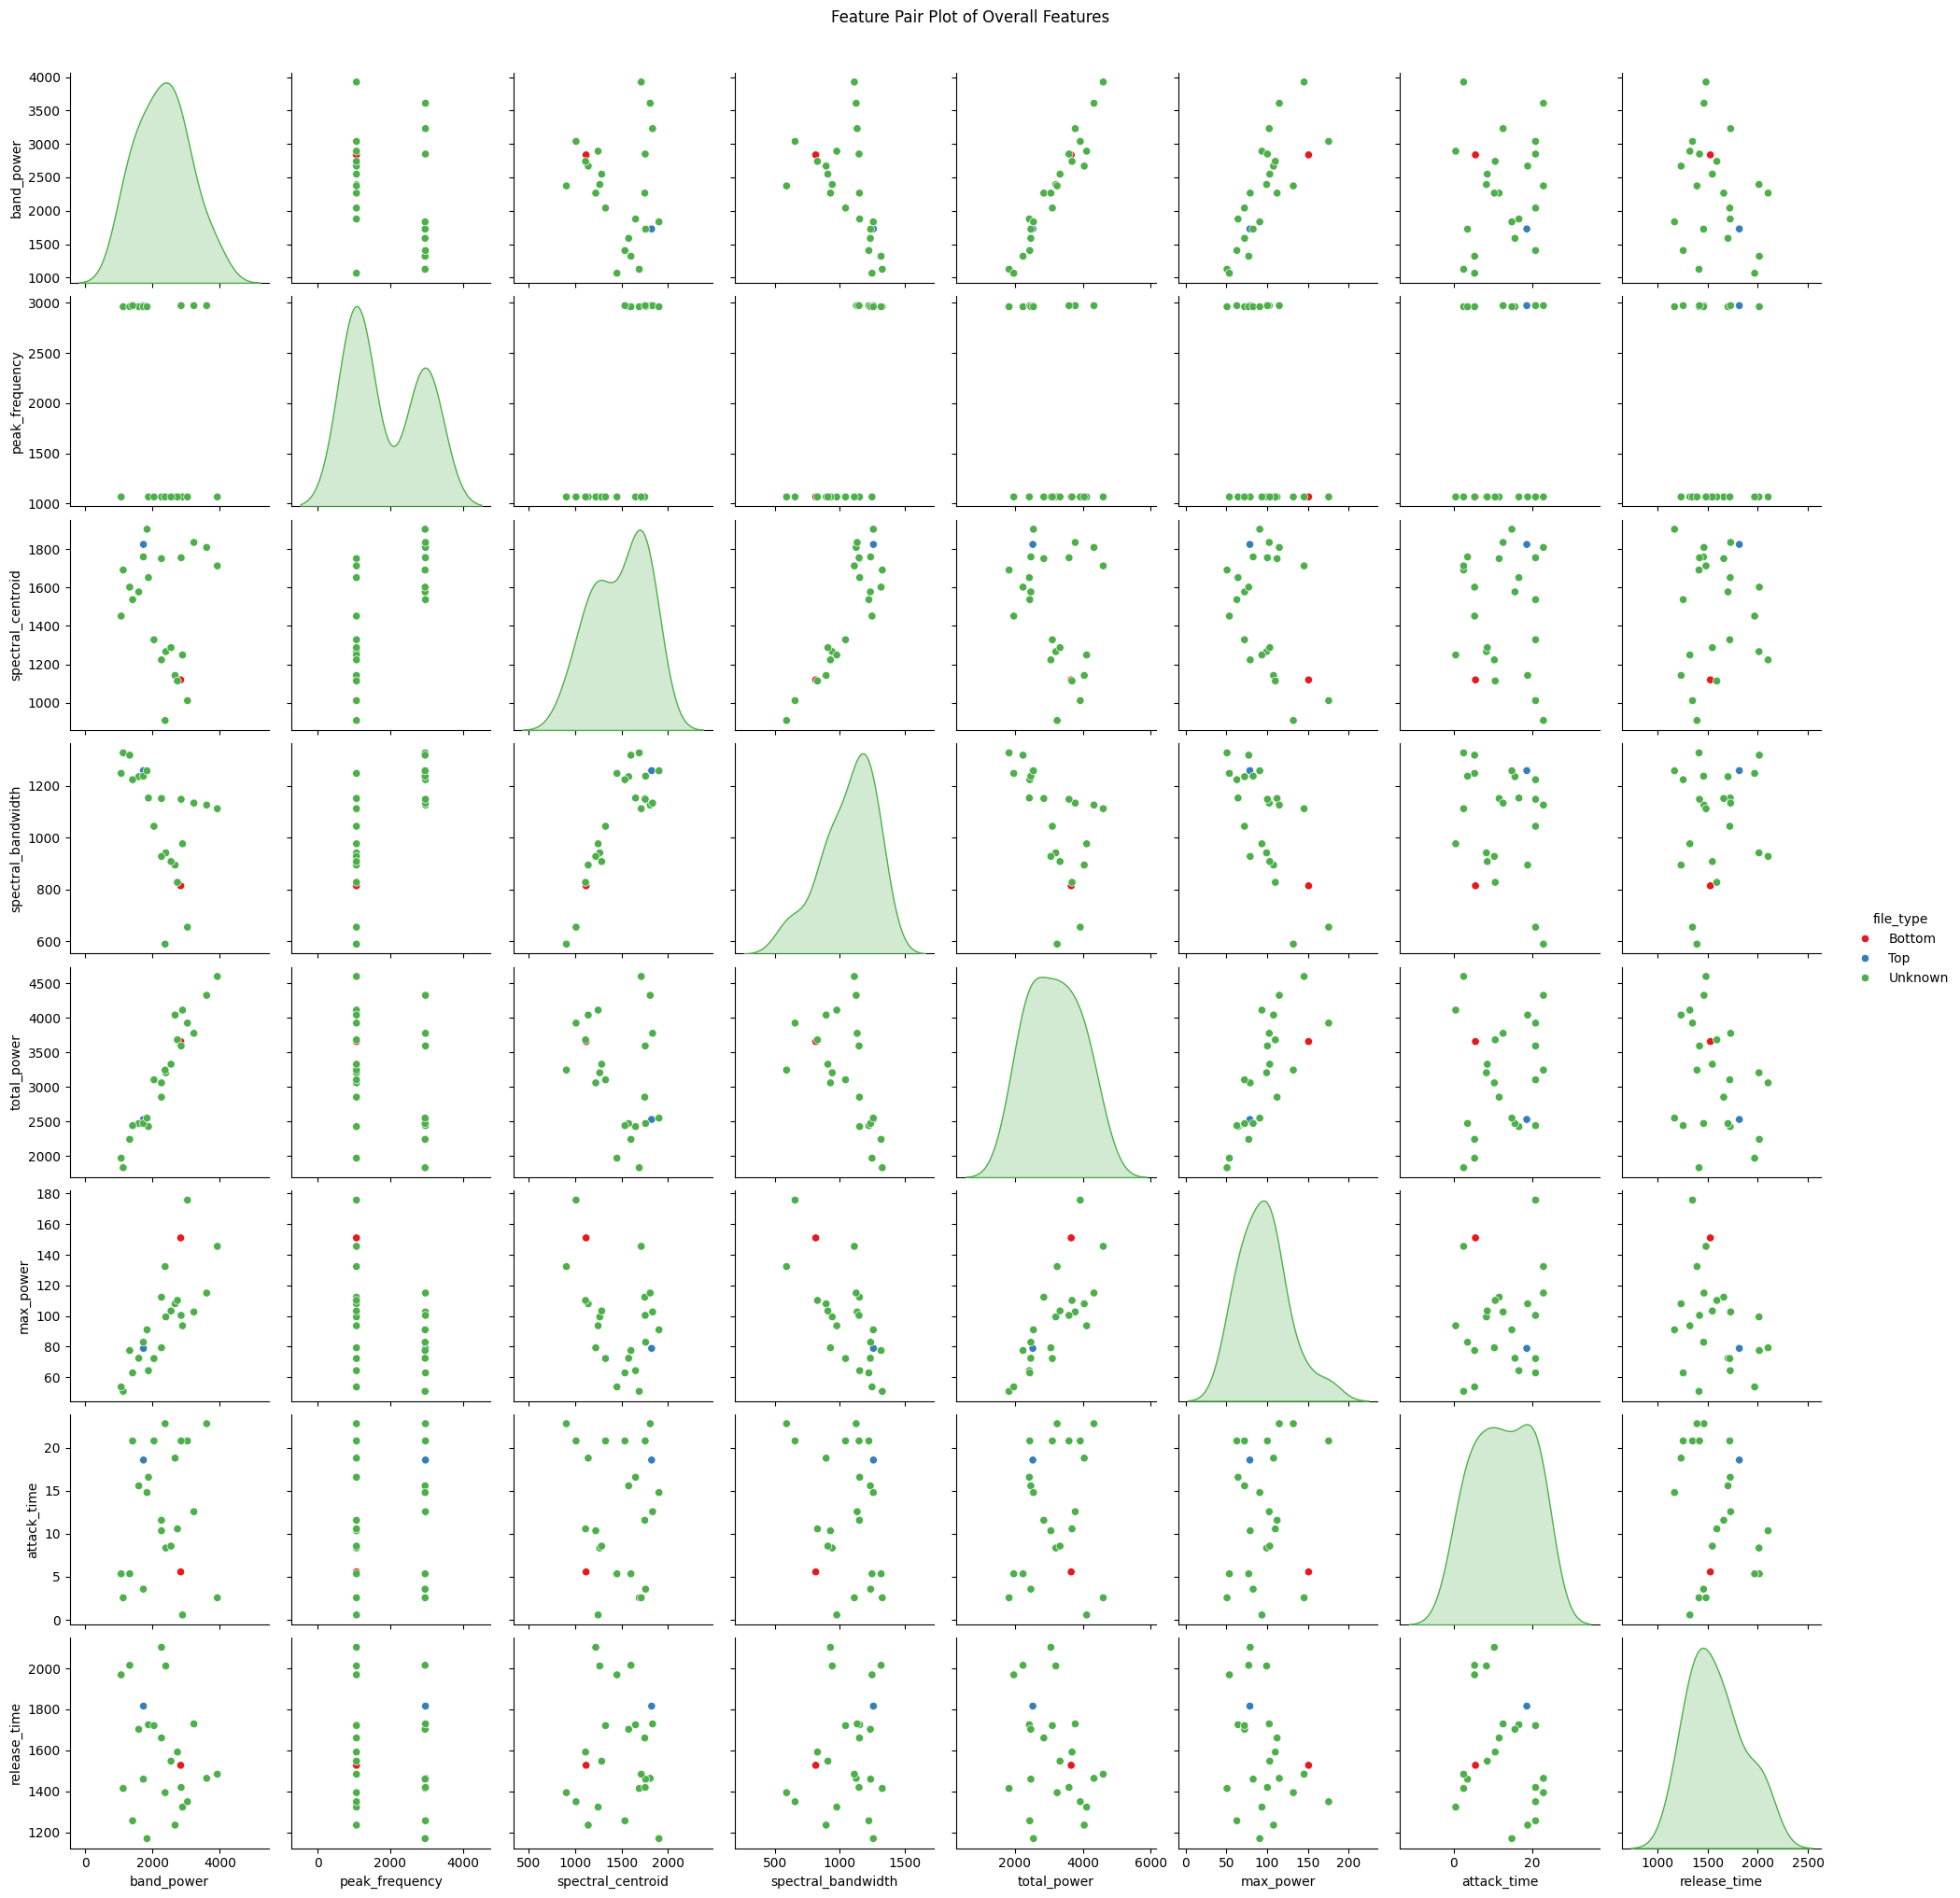

In [13]:

plot_feature_pairs(features_df, feature_cols= overall_features,  title="Feature Pair Plot of Overall Features")

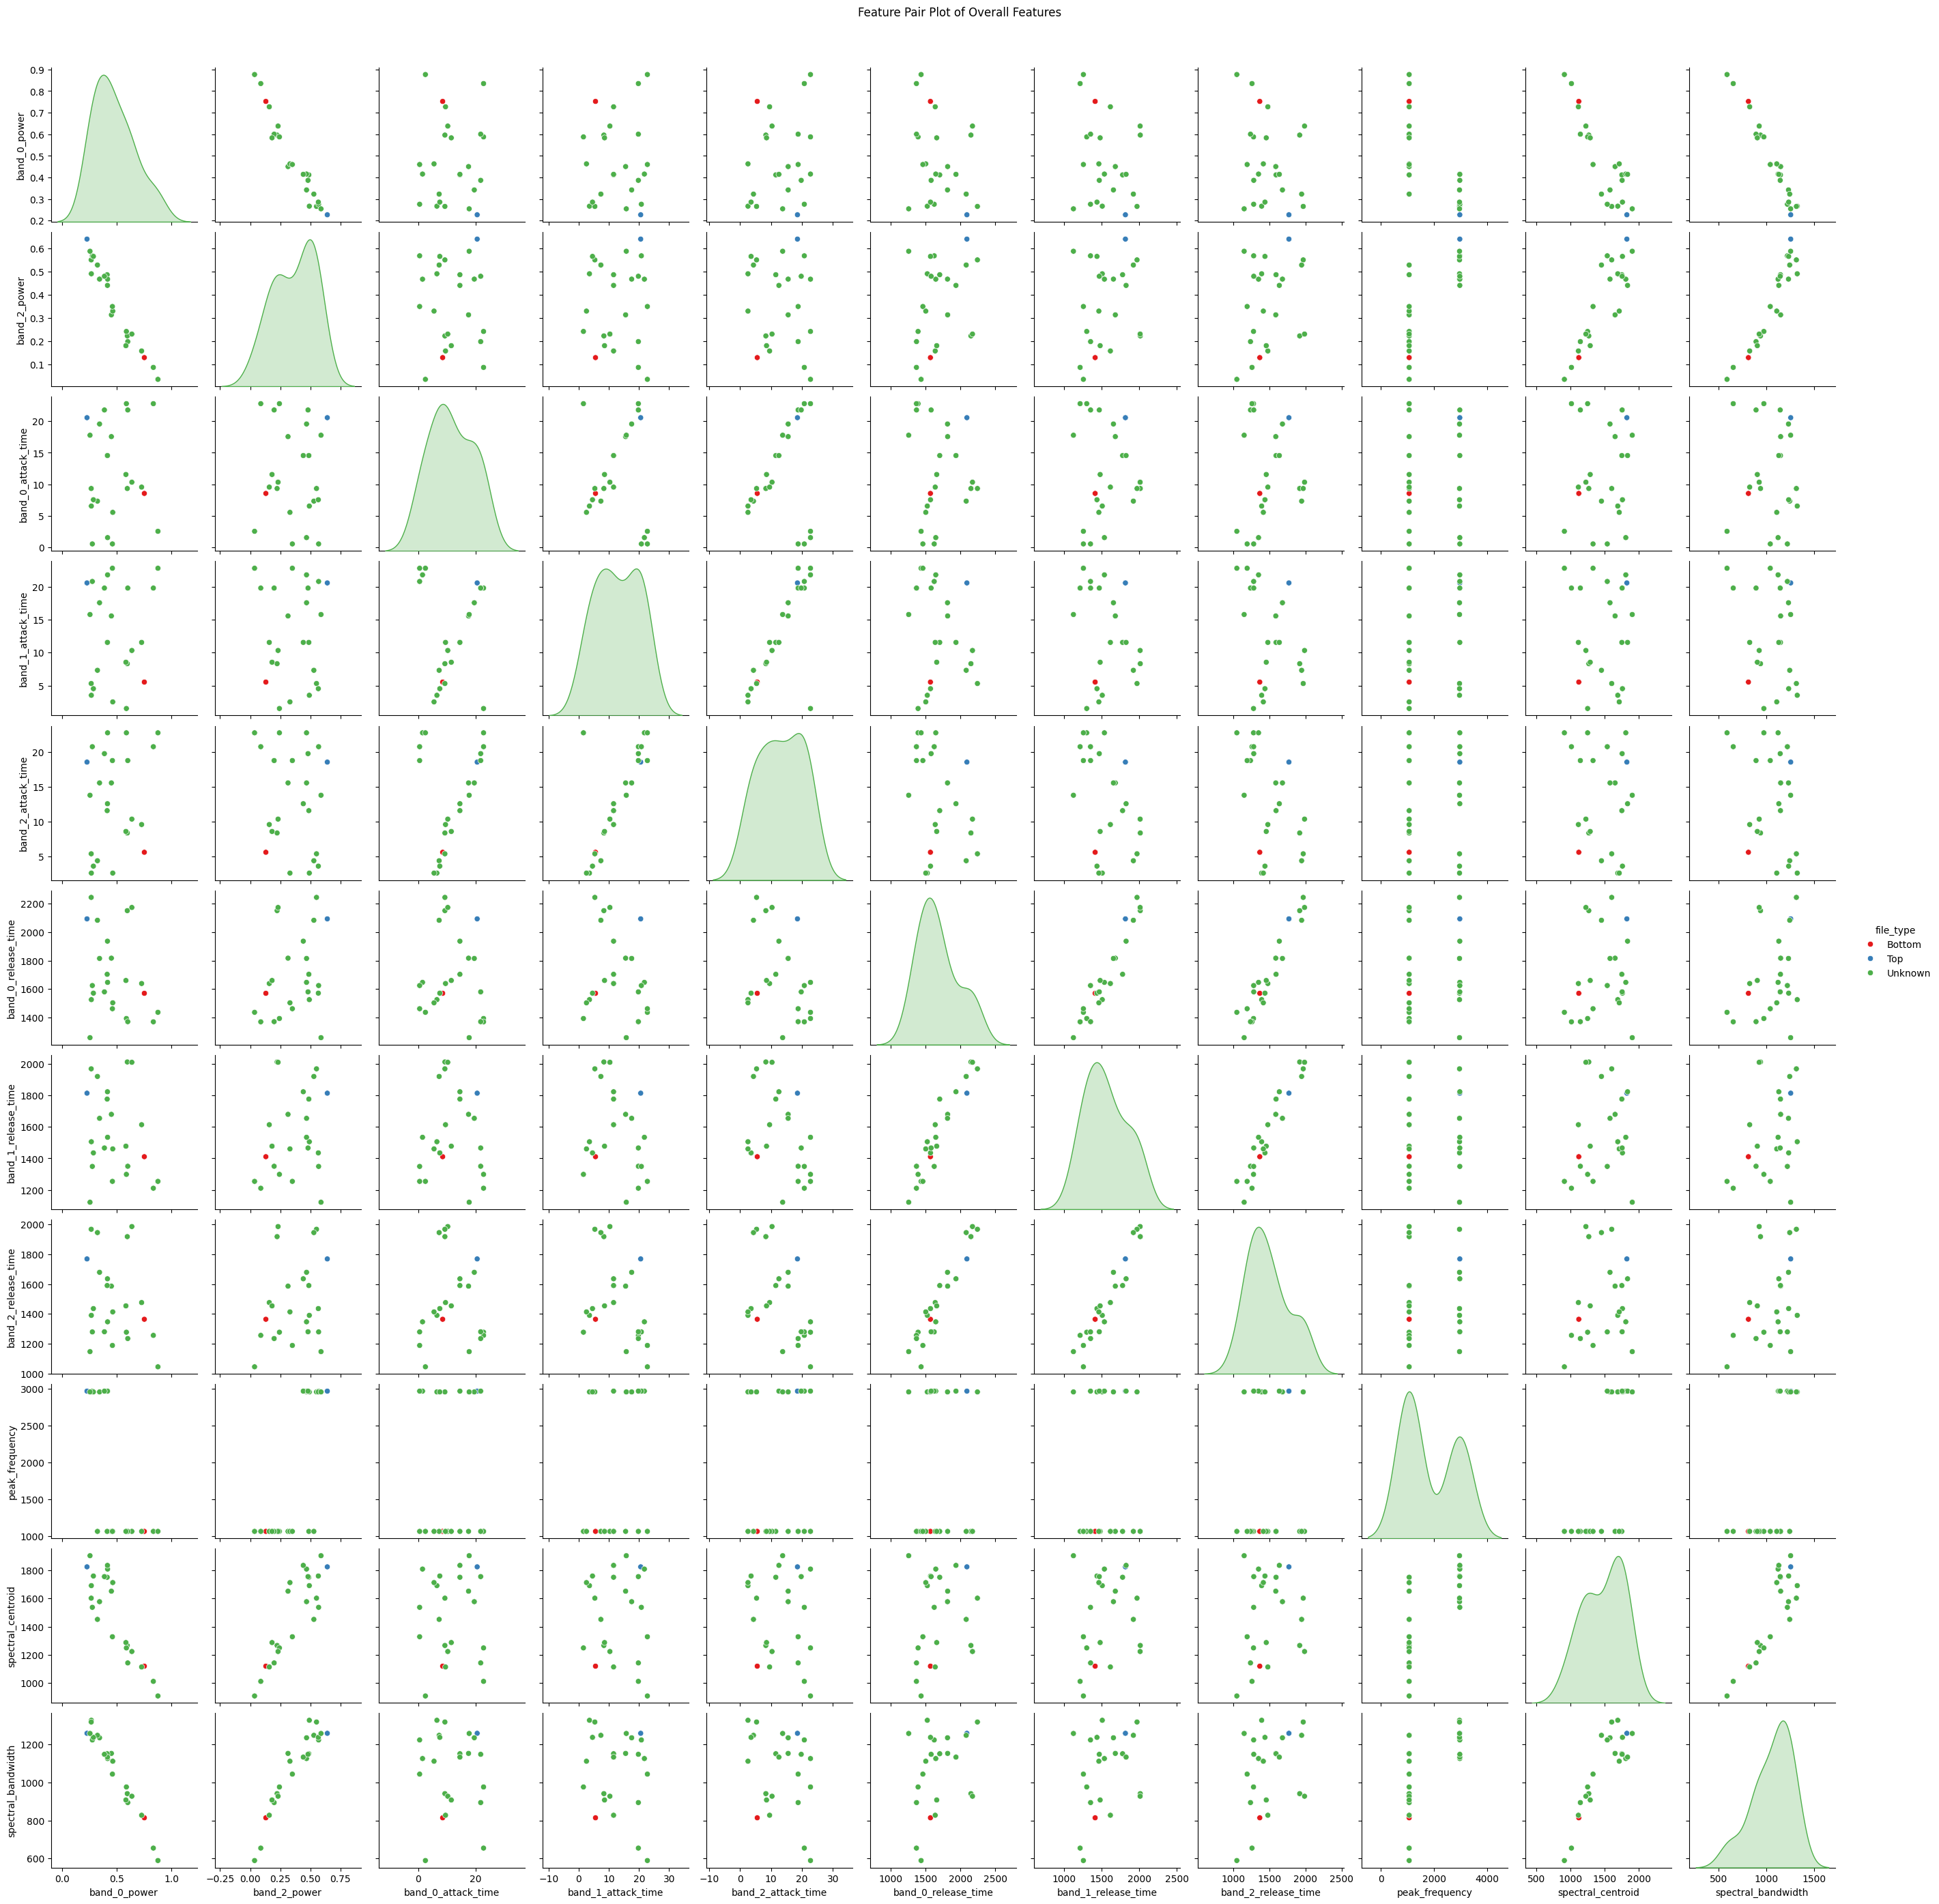

In [14]:

important_features = ['band_0_power', 'band_2_power'
                      , 'band_0_attack_time', 'band_1_attack_time', 'band_2_attack_time'
                      , 'band_0_release_time', 'band_1_release_time', 'band_2_release_time'
                      , 'peak_frequency', 'spectral_centroid', 'spectral_bandwidth']
## We see that these are the features that seem to most predictably separate the top and bottom strikes
plot_feature_pairs(features_df, feature_cols= important_features,  title="Feature Pair Plot of Overall Features")
### Let's add the power in these ranges as features

In [15]:
## Now let's classify: 
### We will demean the data using the important features, and then determine how much like the "top" or "bottom" sound each one is. 
### Basically, determine if the data is more like the top or bottom sound, and then classify it as such.
key_columns = ['file_name', 'file_type']
important_features = ['band_0_power', 'band_2_power'
                      , 'band_0_attack_time', 'band_1_attack_time', 'band_2_attack_time'
                      , 'band_0_release_time', 'band_1_release_time', 'band_2_release_time'
                      , 'peak_frequency']

# Create a copy of the relevant columns
final_features = features_df[key_columns + important_features].copy()

# Normalize features (across all samples, not per row)
scaler = StandardScaler()
final_features[important_features] = scaler.fit_transform(final_features[important_features])

# Get the average feature vectors for "Top" and "Bottom" classes
bottom_prototype = final_features[final_features['file_type'] == "Bottom"][important_features].values
top_prototype = final_features[final_features['file_type'] == "Top"][important_features].values
difference_weights = np.abs(top_prototype - bottom_prototype)
normalized_weights = difference_weights.flatten() / difference_weights.sum()
### the difference between the top and bottom is a signal to noise ratio since we've normalized the data

# Function to calculate cosine similarity 
def calculate_cosine_similarity(row, prototype_vector, weights = None):
    """
    Calculate cosine similarity between a row and a prototype vector
    Returns cosine similarity (higher means more similar)
    """
    # Extract feature values from the row
    row_vector = row.values
    
    # Reshape to 2D arrays as required by cosine_similarity
    row_vector = row_vector.reshape(1, -1)
    prototype_vector = prototype_vector.reshape(1, -1)
    
    # Calculate similarity (not distance, so we don't use 1-similarity)
    if weights is not None:
        # Apply weights to the row vector
        row_vector = row_vector * weights
        prototype_vector = prototype_vector * weights
 
    similarity = cosine_similarity(row_vector, prototype_vector)[0][0]
    
    return similarity

## Calculate the similarities without weights
# Calculate similarities to each prototype
final_features['similarity_to_bottom_nowgt'] = final_features[important_features].apply(
    lambda x: calculate_cosine_similarity(x, bottom_prototype, None), axis=1)
final_features['similarity_to_top_nowgt'] = final_features[important_features].apply(
    lambda x: calculate_cosine_similarity(x, top_prototype, weights = None), axis=1)  
# Determine predicted class based on higher similarity
final_features['predicted_type_nowgt'] = final_features.apply(
    lambda x: 'Top' if x['similarity_to_top_nowgt'] > x['similarity_to_bottom_nowgt'] else 'Bottom', axis=1)

## Calculate the similarities with weights
# Calculate similarities to each prototype
final_features['similarity_to_bottom'] = final_features[important_features].apply(
    lambda x: calculate_cosine_similarity(x, bottom_prototype, difference_weights), axis=1)
final_features['similarity_to_top'] = final_features[important_features].apply(
    lambda x: calculate_cosine_similarity(x, top_prototype, difference_weights), axis=1)
# Determine predicted class based on higher similarity
final_features['predicted_type'] = final_features.apply(
    lambda x: 'Top' if x['similarity_to_top'] > x['similarity_to_bottom'] else 'Bottom', axis=1)

In [16]:
print(final_features)
print(difference_weights)

           file_name file_type  band_0_power  band_2_power  \
0         bottom.csv    Bottom      1.467593     -1.338432   
1            top.csv       Top     -1.329161      1.567480   
2   unlabeled_00.csv   Unknown     -0.140065     -0.290079   
3   unlabeled_10.csv   Unknown      0.636795     -0.806384   
4   unlabeled_15.csv   Unknown     -0.344978      0.693924   
5   unlabeled_22.csv   Unknown     -0.716378      0.585941   
6   unlabeled_23.csv   Unknown     -1.117428      0.717006   
7   unlabeled_25.csv   Unknown      0.591834     -0.697047   
8   unlabeled_26.csv   Unknown      1.907845     -1.578591   
9   unlabeled_27.csv   Unknown     -0.324832      0.584429   
10  unlabeled_31.csv   Unknown      0.858815     -0.761093   
11  unlabeled_37.csv   Unknown      0.658980     -0.946252   
12  unlabeled_38.csv   Unknown     -1.123161      1.057285   
13  unlabeled_42.csv   Unknown     -1.069253      1.157286   
14  unlabeled_45.csv   Unknown     -0.331516      0.431705   
15  unla

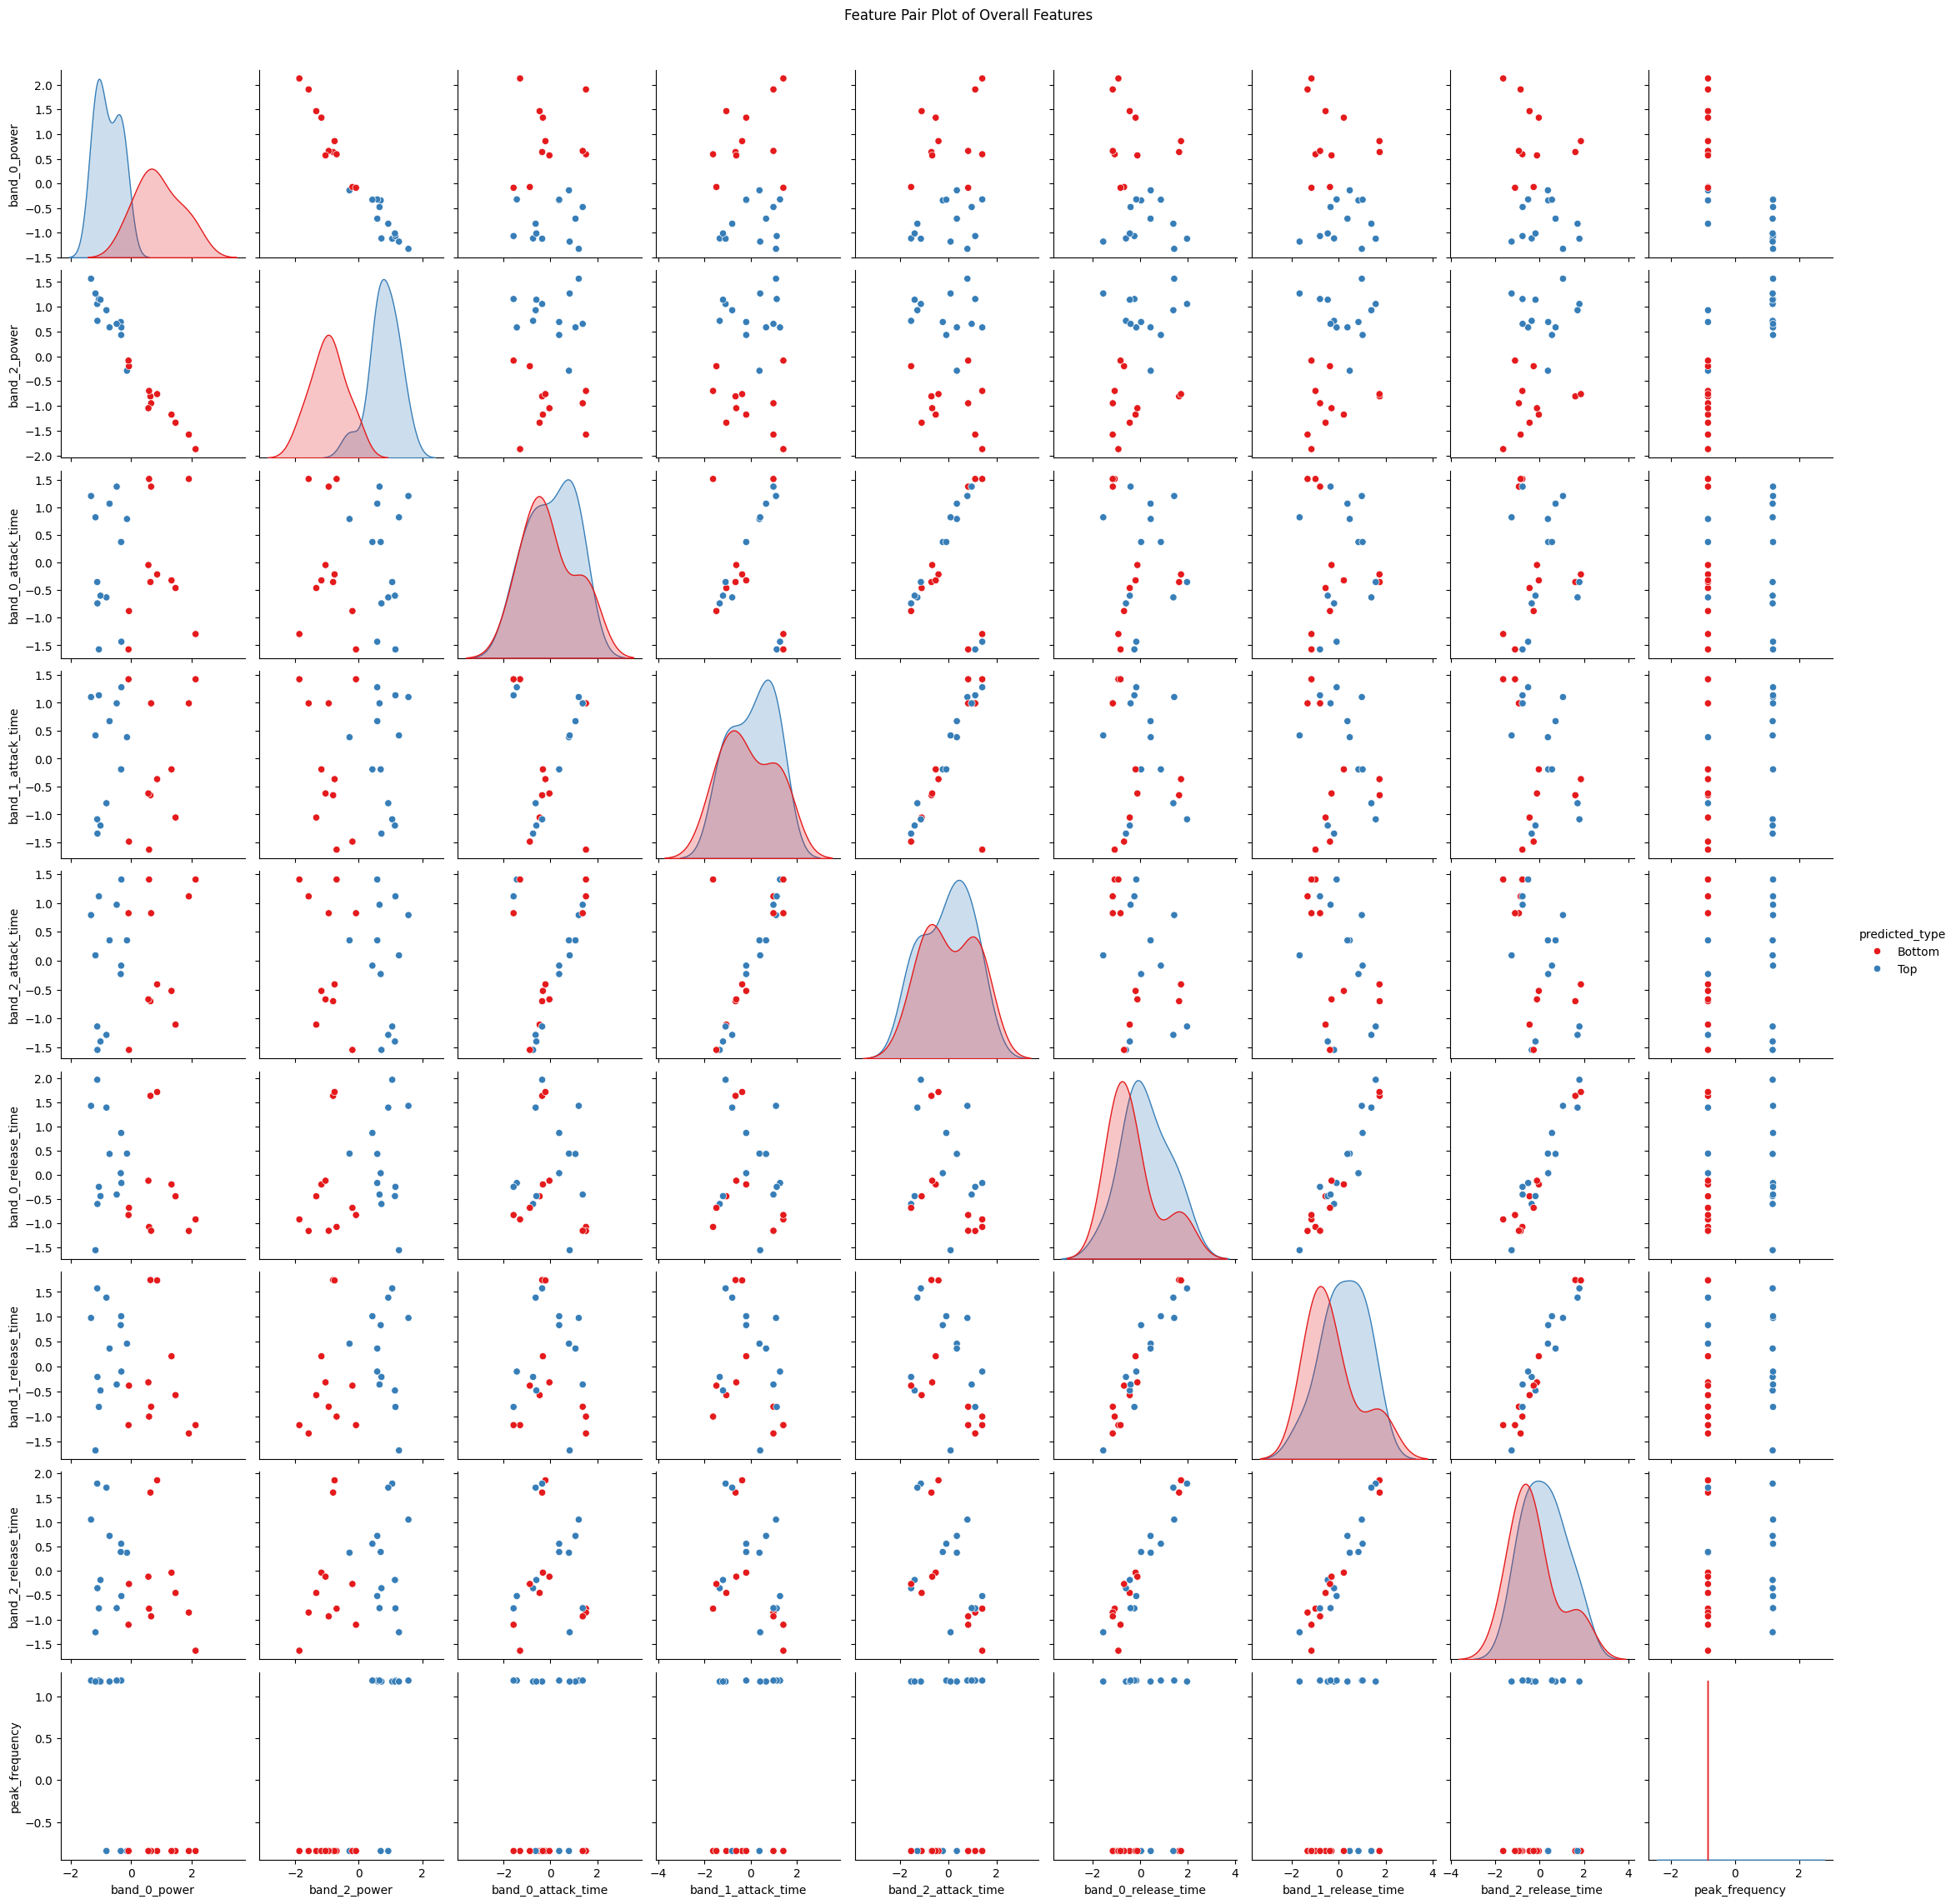

In [17]:
plot_feature_pairs(final_features, feature_cols= important_features,  title="Feature Pair Plot of Overall Features", hue="predicted_type")

In [18]:
# Calculate and display the SNR weights
# First, normalize the difference weights to sum to 1

# Create a DataFrame to show the weights
weight_df = pd.DataFrame({
    'Feature': important_features,
    'Signal': difference_weights.flatten(),
    'Normalized Weight': normalized_weights
})

# Sort by weight in descending order
weight_df = weight_df.sort_values('Normalized Weight', ascending=False)

print("=== Signal-to-Noise Weights ===")
print(weight_df)
 

# Compare classifications with and without weights
comparison_df = final_features[['file_name', 'file_type', 
                                'predicted_type_nowgt', 'predicted_type', 
                                'similarity_to_bottom_nowgt', 'similarity_to_top_nowgt',
                                'similarity_to_bottom', 'similarity_to_top']]

# Add a column to indicate if the predictions differ
comparison_df['predictions_differ'] = (comparison_df['predicted_type_nowgt'] != comparison_df['predicted_type'])
 
# Create confusion matrices
print("\n=== Unweighted Confusion Matrix ===")
unweighted_confusion = pd.crosstab(
    comparison_df['file_type'], 
    comparison_df['predicted_type_nowgt'],
    rownames=['Actual'], 
    colnames=['Predicted'], 
    margins=True
)
print(unweighted_confusion)

print("\n=== Weighted Confusion Matrix ===")
weighted_confusion = pd.crosstab(
    comparison_df['file_type'], 
    comparison_df['predicted_type'],
    rownames=['Actual'], 
    colnames=['Predicted'], 
    margins=True
)
print(weighted_confusion)

# Show samples where the predictions differ
diff_predictions = comparison_df[comparison_df['predictions_differ']] 

=== Signal-to-Noise Weights ===
               Feature    Signal  Normalized Weight
1         band_2_power  2.905913           0.158025
0         band_0_power  2.796754           0.152088
3   band_1_attack_time  2.157821           0.117343
8       peak_frequency  2.034102           0.110615
4   band_2_attack_time  1.899939           0.103319
5  band_0_release_time  1.873982           0.101908
2   band_0_attack_time  1.670580           0.090847
6  band_1_release_time  1.544635           0.083998
7  band_2_release_time  1.505272           0.081857

=== Unweighted Confusion Matrix ===
Predicted  Bottom  Top  All
Actual                     
Bottom          1    0    1
Top             0    1    1
Unknown        10   12   22
All            11   13   24

=== Weighted Confusion Matrix ===
Predicted  Bottom  Top  All
Actual                     
Bottom          1    0    1
Top             0    1    1
Unknown        10   12   22
All            11   13   24


C:\Users\pkress\AppData\Local\Temp\ipykernel_43724\2591788799.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df['predictions_differ'] = (comparison_df['predicted_type_nowgt'] != comparison_df['predicted_type'])


Explained variance by PC1: 41.42%
Explained variance by PC2: 26.75%
Total explained variance: 68.17%


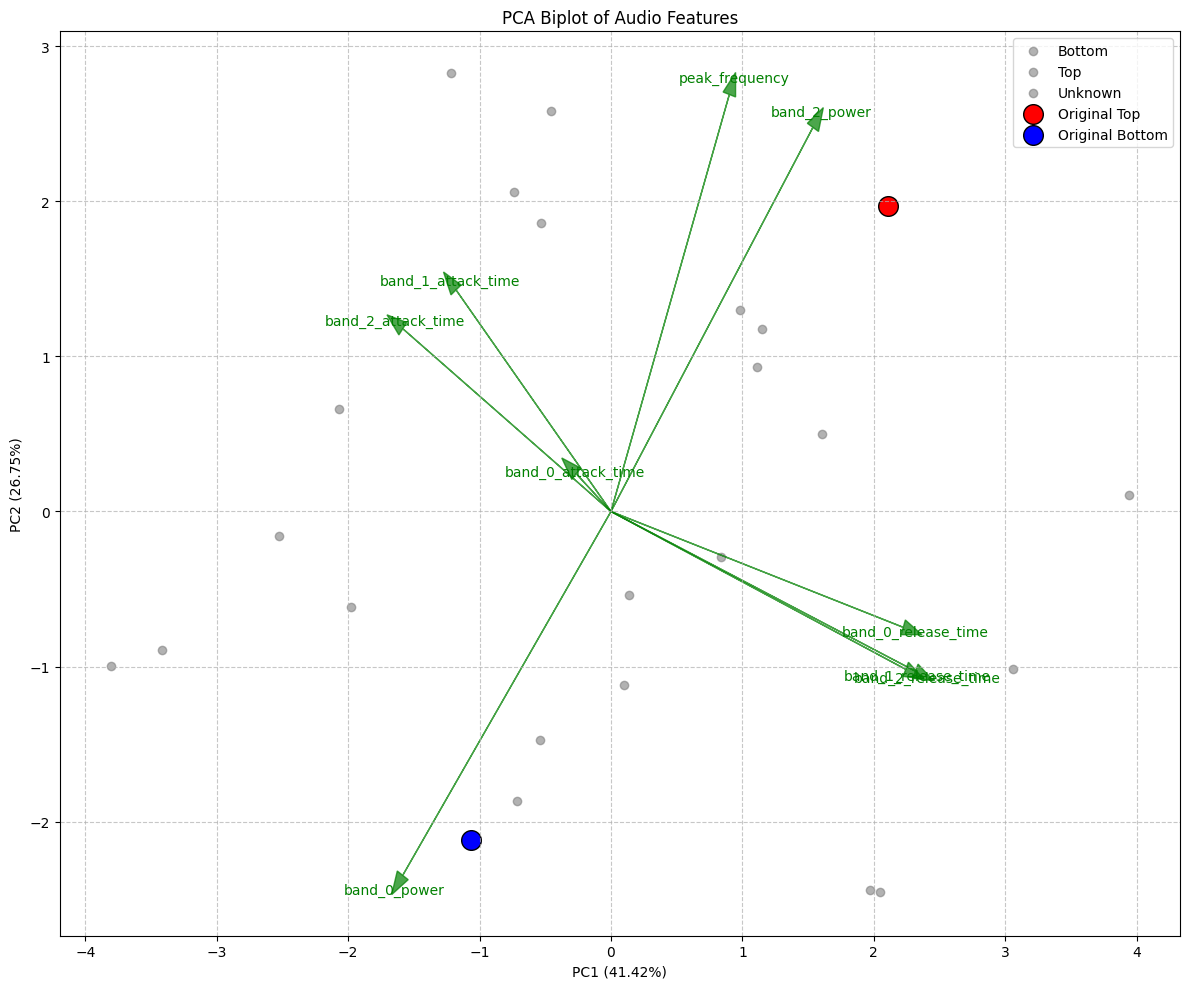

In [19]:

# Perform PCA on the important features
# Use the already normalized data
X = final_features[important_features].values

# Create PCA model with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# Add file information and classification results
pca_df['file_name'] = final_features['file_name']
pca_df['file_type'] = final_features['file_type']
pca_df['predicted_type'] = final_features['predicted_type']  # Weighted prediction

# Display explained variance
explained_variance = pca.explained_variance_ratio_ * 100
print(f"Explained variance by PC1: {explained_variance[0]:.2f}%")
print(f"Explained variance by PC2: {explained_variance[1]:.2f}%")
print(f"Total explained variance: {sum(explained_variance):.2f}%")
 
# Create biplot (combining scatter plot with feature loading vectors)
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(12, 10))
    
    # Plot samples by class, not using map function which caused the error
    for class_type in pca_df['file_type'].unique():
        class_data = pca_df[pca_df['file_type'] == class_type]
        class_indices = class_data.index
        plt.scatter(score[class_indices, 0], score[class_indices, 1], 
                    c='gray', 
                    label=class_type,
                    alpha=0.6)
    
    # Plot feature loadings
    for i, feature in enumerate(labels):
        plt.arrow(0, 0, coeff[i, 0]*5, coeff[i, 1]*5, color='green', alpha=0.7, head_width=0.1)
        plt.text(coeff[i, 0]*5.2, coeff[i, 1]*5.2, feature, color='green', ha='center', va='center')
    
    # Add original samples with bigger markers
    top_indices = np.where(pca_df['file_type'] == 'Top')[0]
    bottom_indices = np.where(pca_df['file_type'] == 'Bottom')[0] 
    plt.scatter(score[top_indices[0], 0], score[top_indices[0], 1], 
                c='red', s=200, edgecolors='black', label='Original Top')
 
    plt.scatter(score[bottom_indices[0], 0], score[bottom_indices[0], 1], 
                c='blue', s=200, edgecolors='black', label='Original Bottom')

    # Add axis labels and title
    plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
    plt.title('PCA Biplot of Audio Features')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call biplot function
biplot(principalComponents, pca.components_.T, important_features)

In [20]:
## Export the means and stds to allow standardizing
## Export the reference (top/bottom) data for the important dimensions to allow for comparison
## Export the weights to weight the comparison features
## Set those up in in a function that can be called to classify new data
classifier_features = important_features
means = scaler.mean_
stds = scaler.scale_
weights = difference_weights.flatten()
bottom_prototype = bottom_prototype.flatten()
top_prototype = top_prototype.flatten()
bands = [(750, 1400), (1600, 2000), (2600, 3200), (3500, 4000)]
print(classifier_features)
print(means)
print(stds)
print(weights)
print(bottom_prototype)
print(top_prototype)
print(bands)




['band_0_power', 'band_2_power', 'band_0_attack_time', 'band_1_attack_time', 'band_2_attack_time', 'band_0_release_time', 'band_1_release_time', 'band_2_release_time', 'peak_frequency']
[4.76993993e-01 3.65619867e-01 1.18609221e+01 1.28884165e+01
 1.31475813e+01 1.69287075e+03 1.55832851e+03 1.48647449e+03
 1.85768738e+03]
[1.87617691e-01 1.75739236e-01 7.18313494e+00 6.95145742e+00
 6.84232406e+00 2.78582688e+02 2.60876576e+02 2.69027287e+02
 9.36869530e+02]
[2.79675393 2.90591263 1.67057978 2.15782088 1.89993924 1.87398205
 1.54463536 1.50527178 2.03410231]
[ 1.4675927  -1.3384323  -0.45952519 -1.05421429 -1.10890547 -0.43963221
 -0.56529173 -0.45369842 -0.84514844]
[-1.32916124  1.56748033  1.21105459  1.10360659  0.79103378  1.43434984
  0.97934363  1.05157336  1.18895387]
[(750, 1400), (1600, 2000), (2600, 3200), (3500, 4000)]


In [21]:
import os
import numpy as np
import pandas as pd
import librosa
from typing import TypeVar
from sklearn.metrics.pairwise import cosine_similarity
# Function to read data
def read_spectrogram(file_name: str) -> pd.DataFrame:
    """
    Read spectrograms from CSV file where:
    - Row indices are frequency bands in Hz
    - Column names are time slices in milliseconds
    """
    # Load spectrogram
    spectrogram = pd.read_csv(file_name, index_col=0)
    
    # Convert column names to float (time values)
    spectrogram.columns = spectrogram.columns.astype(float)
    
    # Return spectrogram
    return spectrogram

def extract_spectral_features(spec_data: pd.DataFrame, bands: list) -> dict:
    """
    Extract numerical features from the spectrogram that could be useful for classification
    
    Args:
        spec_data: DataFrame containing the spectrogram data
        bands: List of tuples specifying frequency bands to analyze [(low1, high1), (low2, high2), ...]
        
    Returns:
        features: Dictionary of extracted features
    """
    # Get frequency and time values
    freq_values = spec_data.index.astype(float).values
    
    # Calculate frequency distribution
    freq_power = spec_data.sum(axis=1)
    time_power = spec_data.sum(axis=0)
    
    # Find peak frequency (frequency with maximum power)
    peak_freq_idx = freq_power.argmax()
    peak_frequency = freq_values[peak_freq_idx]
    
    # Calculate spectral centroid (weighted average of frequencies)
    spectral_centroid = np.sum(freq_values * freq_power) / np.sum(freq_power)
    
    # Calculate spectral bandwidth (weighted standard deviation of frequencies)
    spectral_bandwidth = np.sqrt(np.sum(((freq_values - spectral_centroid) ** 2) * freq_power) / np.sum(freq_power))
    
    # Calculate power in the bands
    band_power = []
    for band in bands:
        low_freq, high_freq = band
        band_mask = (freq_values >= low_freq) & (freq_values < high_freq)
        band_power.append(np.sum(freq_power[band_mask]))    

    total_band_power = np.sum(band_power)
    for i in range(len(band_power)):
        band_power[i] /= total_band_power  
 
    # Calculate temporal features
    max_power = np.max(time_power)
    max_power_idx = time_power.argmax()
    last_silence_idx = time_power[:max_power_idx][time_power < (0.01 * max_power)].index[-1]
    release_10pct_idx = time_power[time_power > (0.1 * max_power)].index[-1]
        
    attack_time = max_power_idx - last_silence_idx
    release_time = release_10pct_idx - max_power_idx 

    peak_time_idx = time_power.argmax()
    peak_time = time_power.index[peak_time_idx]

    ## Attack/release for each band    
    attack_times = []
    release_times = []
    for band in bands:
        low_freq, high_freq = band
        band_mask = (freq_values >= low_freq) & (freq_values < high_freq)
        band_time_power = spec_data[band_mask].sum(axis=0)

        max_power = np.max(band_time_power)
        max_power_idx = band_time_power.argmax()
        last_silence_idx = band_time_power[:max_power_idx][band_time_power < (0.01 * max_power)].index[-1]
        release_10pct_idx = band_time_power[band_time_power > (0.1 * max_power)].index[-1]
         
        attack_times.append(max_power_idx - last_silence_idx)
        release_times.append(release_10pct_idx - max_power_idx)
     
    
    # Return features as a dictionary
    features = {
        'peak_frequency': peak_frequency,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,  
        'peak_time': peak_time,
        'total_power': np.sum(spec_data.values),
        'max_power': np.max(spec_data.values), 
        'attack_time': attack_time,
        'release_time': release_time,
        'band_power': total_band_power,
        ## Add the band powers
        **{f'band_{i}_power': band_power[i] for i in range(len(band_power))},
        ## Add the band attack/release times
        **{f'band_{i}_attack_time': attack_times[i] for i in range(len(attack_times))}, 
        **{f'band_{i}_release_time': release_times[i] for i in range(len(release_times))}, 
    }
    
    return features 

def classify_preprocessed_audio(fpath: str) -> int:
    """
    Classify preprocessed audio as top (0) or bottom (1)
    
    Args:
        fpath: Path to CSV file containing preprocessed audio spectrogram
        
    Returns:
        0 if top, 1 if bottom, None if unable to classify
    """  
    # Read spectrogram
    spec_data = read_spectrogram(fpath) 
    
    # Extract features
    features = extract_spectral_features(spec_data, bands=[(750, 1400), (1600, 2000), (2600, 3200), (3500, 4000)])
    # Define important features based on analysis
    important_features = [
        'band_0_power', 'band_2_power',
        'band_0_attack_time', 'band_1_attack_time', 'band_2_attack_time',
        'band_0_release_time', 'band_1_release_time', 'band_2_release_time',
        'peak_frequency'
    ] 
   
    # Normalize using typical values (approximating StandardScaler)
    feature_means = np.array([
        4.76993993e-01,  # band_0_power
        3.65619867e-01,  # band_2_power
        1.18609221e+01,    # band_0_attack_time
        1.31475813e+01,    # band_1_attack_time
        1.28884165e+01,    # band_2_attack_time
        1.69287075e+03,   # band_0_release_time
        1.55832851e+03,   # band_1_release_time
        1.48647449e+03,   # band_2_release_time
        1.85768738e+03  # peak_frequency 
    ])
     
    feature_stds = np.array([
        1.87617691e-01,  # band_0_power
        1.75739236e-01,  # band_2_power
        7.18313494e+00,     # band_0_attack_time
        6.95145742e+00,     # band_1_attack_time
        6.84232406e+00,     # band_2_attack_time
        2.78582688e+02,     # band_0_release_time
        2.60876576e+02,     # band_1_release_time
        2.69027287e+02,     # band_2_release_time
        9.36869530e+02   # peak_frequency 
        ])
    # Prototype feature values for "top" class (0)
    top_prototype = {
        'band_0_power': -1.32916124,
        'band_2_power': 1.56748033 ,
        'band_0_attack_time': 1.21105459,
        'band_1_attack_time':  1.10360659,
        'band_2_attack_time': 0.79103378,
        'band_0_release_time': 1.43434984,
        'band_1_release_time': 0.97934363 ,
        'band_2_release_time': 1.05157336,
        'peak_frequency': 1.18895387 
    }
       
    # Prototype feature values for "bottom" class (1)
    bottom_prototype = {
        'band_0_power': 1.4675927,
        'band_2_power': -1.3384323,
        'band_0_attack_time': -0.45952519,
        'band_1_attack_time':-1.05421429,
        'band_2_attack_time': -1.10890547,
        'band_0_release_time': -0.43963221 ,
        'band_1_release_time': -0.56529173,
        'band_2_release_time': -0.45369842,
        'peak_frequency': -0.84514844 
    }
     
    # Feature weights (signal-to-noise ratio)
    feature_weights = {
        'band_0_power': 2.79675393,
        'band_2_power': 2.90591263,
        'band_0_attack_time': 1.67057978,
        'band_1_attack_time': 2.15782088,
        'band_2_attack_time': 1.89993924,
        'band_0_release_time': 1.87398205,
        'band_1_release_time': 1.54463536,
        'band_2_release_time': 1.50527178,
        'peak_frequency': 2.03410231, 
    }
    
    # Create feature vectors
    feature_vector = np.array([features.get(f) for f in important_features])
    
    
    # Apply normalization
    feature_vector_norm = (feature_vector - feature_means) / feature_stds
    
    # Get the prototype vectors for top and bottom classes
    top_vector_norm = np.array([top_prototype.get(f) for f in important_features])
    bottom_vector_norm = np.array([bottom_prototype.get(f) for f in important_features])
    weights = np.array([feature_weights.get(f) for f in important_features])
    
    # Apply weights
    feature_vector_weighted = feature_vector_norm * weights
    top_vector_weighted = top_vector_norm * weights
    bottom_vector_weighted = bottom_vector_norm * weights
    
    # Calculate cosine similarity
    similarity_to_top = cosine_similarity(
        feature_vector_weighted.reshape(1, -1), 
        top_vector_weighted.reshape(1, -1)
    )[0][0]
    
    similarity_to_bottom = cosine_similarity(
        feature_vector_weighted.reshape(1, -1), 
        bottom_vector_weighted.reshape(1, -1)
    )[0][0]
    
    print(f"Similarity to Top: {similarity_to_top:.4f}")
    print(f"Similarity to Bottom: {similarity_to_bottom:.4f}")
    print(f"Predicted Class: {'Top' if similarity_to_top > similarity_to_bottom else 'Bottom'}")

    # Return classification (0 for top, 1 for bottom)
    return 0 if similarity_to_top > similarity_to_bottom else 1


In [22]:
## Let's try it out

# Set up paths 
path_dict = {
    "dir_train":"./train"
    , "dir_inter":"./intermediate"
    , "dir_output":"./output"
    , "dir_logs":"./logs"
    , "dir_models":"./models"
    }    

all_file_paths = os.listdir(path_dict["dir_train"]) 

## Run the classifier
classify_preprocessed_audio(path_dict['dir_train']+"/"+all_file_paths[0])
classify_preprocessed_audio(path_dict['dir_train']+"/"+all_file_paths[1])
classify_preprocessed_audio(path_dict['dir_train']+"/"+all_file_paths[2])
classify_preprocessed_audio(path_dict['dir_train']+"/"+all_file_paths[3])

Similarity to Top: -0.9430
Similarity to Bottom: 0.9999
Predicted Class: Bottom
Similarity to Top: 0.9999
Similarity to Bottom: -0.9428
Predicted Class: Top
Similarity to Top: 0.1414
Similarity to Bottom: -0.0689
Predicted Class: Top
Similarity to Top: -0.2401
Similarity to Bottom: 0.4559
Predicted Class: Bottom


1